<font color="#CC3D3D"><p>
# 트랜잭션 데이터로부터 feature를 생성한 후 학습용과 평가용 데이터로 나누기

- **Input**: 트랜잭션 데이터(`train_transactions.csv`, `test_transactions.csv`)
- **Output**: 위 데이터로부터 파생변수(feature)를 만든 후 모형 학습용(`X_train.csv`)과 평가용(`X_test.csv`) 데이터 생성

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pylab as plt
from matplotlib import font_manager, rc
%matplotlib inline

pd.set_option('max_columns', 20, 'max_rows', 20)

D:\Anaconda3\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
# 차트에서 한글 출력을 위한 설정
import platform
your_os = platform.system()
if your_os == 'Linux':
    rc('font', family='NanumGothic')
elif your_os == 'Windows':
    ttf = "c:/Windows/Fonts/malgun.ttf"
    font_name = font_manager.FontProperties(fname=ttf).get_name()
    rc('font', family=font_name)
elif your_os == 'Darwin':
    rc('font', family='AppleGothic')
rc('axes', unicode_minus=False)

<font color="blue"><p>
## Read Transactions

In [3]:
train = pd.read_csv('train_transactions.csv', encoding='cp949')
test = pd.read_csv('test_transactions.csv', encoding='cp949')
tr = pd.concat([train, test])

In [4]:
tr

,cust_id,tran_date,store_nm,goods_id,gds_grp_nm,gds_grp_mclas_nm,amount
0,0,2007-01-19 00:00:00,강남점,127105,기초 화장품,화장품,850000
1,0,2007-03-30 00:00:00,강남점,342220,니 트,시티웨어,480000
2,0,2007-03-30 00:00:00,강남점,127105,기초 화장품,화장품,3000000
3,0,2007-03-30 00:00:00,강남점,342205,니 트,시티웨어,840000
4,0,2007-03-30 00:00:00,강남점,342220,상품군미지정,기타,20000
...,...,...,...,...,...,...,...
163553,5981,2007-01-12 00:00:00,영등포점,50105,일반가공식품,가공식품,209000
163554,5981,2007-01-12 00:00:00,영등포점,50109,상품군미지정,기타,7150
163555,5981,2007-01-12 00:00:00,영등포점,50105,햄,축산가공,9500
163556,5981,2007-01-12 00:00:00,영등포점,50105,상품군미지정,기타,9500


## Feature Generation

*새로 만든 feature와 병합할 고객ID로만 이루어진 데이터프레임을 만든다.*

In [5]:
features = pd.DataFrame({'cust_id': tr.cust_id.unique()})

**[파생변수 1-4]** 총구매액, 구매건수, 평균구매액, 최대구매액

In [6]:
f = tr.groupby('cust_id')['amount'].agg([
    ('총구매액',np.sum), 
    ('구매건수', np.size), 
    ('평균구매액', lambda x: np.round(np.mean(x))),
    ('최대구매액', np.max),
]).reset_index()
features = features.merge(f, how='left'); features.head()

,cust_id,총구매액,구매건수,평균구매액,최대구매액
0,0,68282840,74,922741,11264000
1,1,2136000,3,712000,2136000
2,2,3197000,4,799250,1639000
3,3,16077620,44,365400,4935000
4,4,29050000,3,9683333,24000000


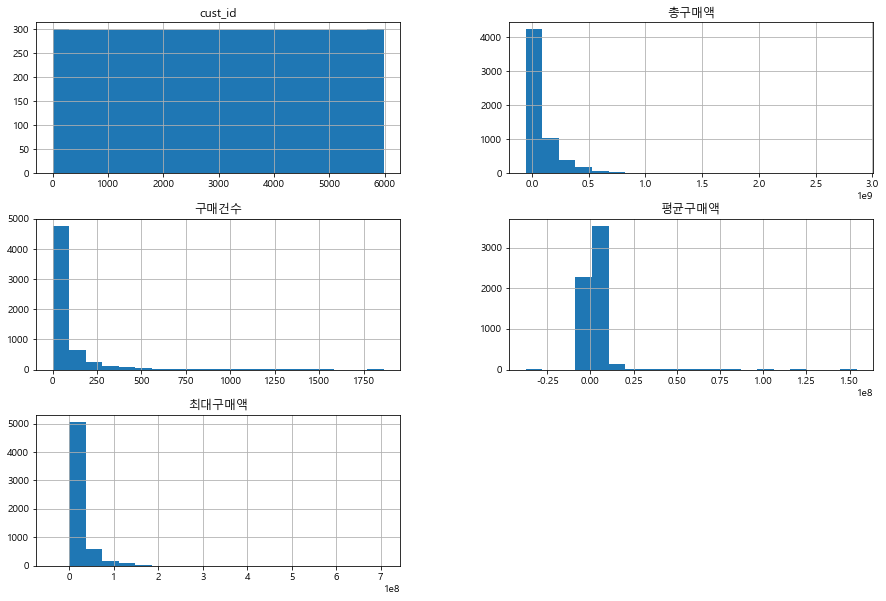

In [7]:
# histogram
f.hist(bins=20, figsize=(15,10))
plt.show()

**[파생변수 5-7]** 구매상품종류(goods_id, gds_grp_nm, gds_grp_mclas_nm 각각)

In [8]:
f = tr.groupby('cust_id').agg({
    'goods_id': [('구매상품종류1', lambda x: x.nunique())],
    'gds_grp_nm': [('구매상품종류2', lambda x: x.nunique())],
    'gds_grp_mclas_nm': [('구매상품종류3', lambda x: x.nunique())]
})

f.columns = f.columns.droplevel()  # 동일한 코드: f.columns = [j for _, j in f.columns]
f=f.reset_index()
features = features.merge(f, how='left'); features.head()

,cust_id,총구매액,구매건수,평균구매액,최대구매액,구매상품종류1,구매상품종류2,구매상품종류3
0,0,68282840,74,922741,11264000,35,28,17
1,1,2136000,3,712000,2136000,2,2,2
2,2,3197000,4,799250,1639000,1,2,2
3,3,16077620,44,365400,4935000,24,20,13
4,4,29050000,3,9683333,24000000,2,3,3


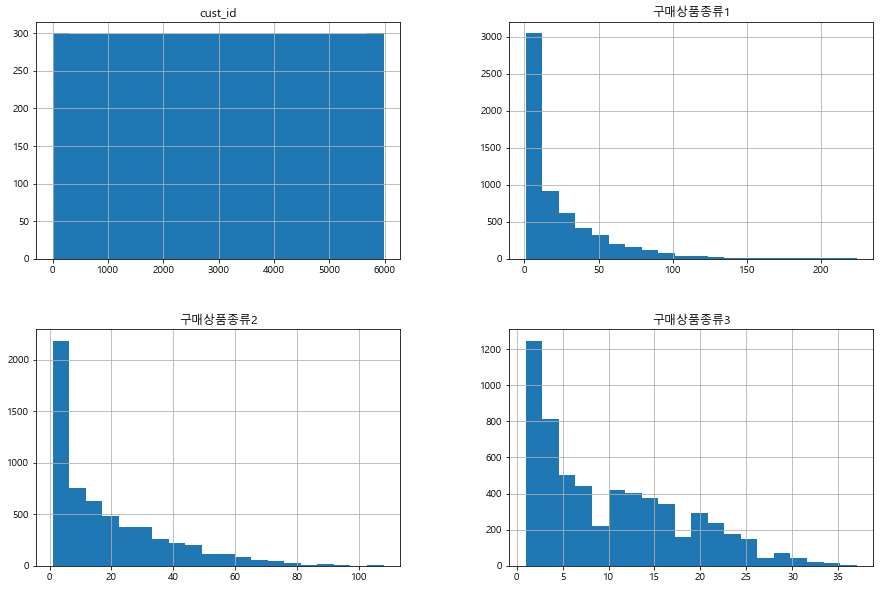

In [9]:
# histogram
f.hist(bins=20, figsize=(15,10))
plt.show()

**[파생변수 8-14]** 내점일수, 구매주기, 주말방문비율, 계절별 구매비율(Spring(3-5)/Summer(6-8)/Fall(9-11)/Winter(12-2))

In [10]:
f = tr.groupby('cust_id')['tran_date'].agg([
    ('내점일수',lambda x: x.str[:10].nunique()),
    ('구매주기', lambda x: int((x.astype('datetime64').max() - x.astype('datetime64').min()).days / x.str[:10].nunique())),
    ('주말방문비율', lambda x: np.mean(pd.to_datetime(x).dt.dayofweek>4)),
    ('봄-구매비율', lambda x: np.mean(pd.to_datetime(x).dt.month.isin([3,4,5]))),
    ('여름-구매비율', lambda x: np.mean(pd.to_datetime(x).dt.month.isin([6,7,8]))),
    ('가을-구매비율', lambda x: np.mean(pd.to_datetime(x).dt.month.isin([9,10,11]))),
    ('겨울-구매비율', lambda x: np.mean(pd.to_datetime(x).dt.month.isin([1,2,12])))
]).reset_index()
features = features.merge(f, how='left'); features.head()

,cust_id,총구매액,구매건수,평균구매액,최대구매액,구매상품종류1,구매상품종류2,구매상품종류3,내점일수,구매주기,주말방문비율,봄-구매비율,여름-구매비율,가을-구매비율,겨울-구매비율
0,0,68282840,74,922741,11264000,35,28,17,19,17,0.527027,0.094595,0.391892,0.378378,0.135135
1,1,2136000,3,712000,2136000,2,2,2,2,1,0.000000,0.000000,0.000000,1.000000,0.000000
2,2,3197000,4,799250,1639000,1,2,2,2,1,0.000000,0.000000,0.000000,0.000000,1.000000
3,3,16077620,44,365400,4935000,24,20,13,18,16,0.318182,0.590909,0.159091,0.113636,0.136364
4,4,29050000,3,9683333,24000000,2,3,3,2,85,0.000000,0.333333,0.000000,0.666667,0.000000


**[파생변수 15-16]** 환불금액, 환불건수

In [11]:
f = tr[tr.amount < 0].groupby('cust_id')['amount'].agg([
    ('환불금액', lambda x: x.sum() * -1),
    ('환불건수', np.size)
]).reset_index()
features = features.merge(f, how='left'); features.head()

,cust_id,총구매액,구매건수,평균구매액,최대구매액,구매상품종류1,구매상품종류2,구매상품종류3,내점일수,구매주기,주말방문비율,봄-구매비율,여름-구매비율,가을-구매비율,겨울-구매비율,환불금액,환불건수
0,0,68282840,74,922741,11264000,35,28,17,19,17,0.527027,0.094595,0.391892,0.378378,0.135135,6860000.0,3.0
1,1,2136000,3,712000,2136000,2,2,2,2,1,0.000000,0.000000,0.000000,1.000000,0.000000,300000.0,1.0
2,2,3197000,4,799250,1639000,1,2,2,2,1,0.000000,0.000000,0.000000,0.000000,1.000000,NaN,NaN
3,3,16077620,44,365400,4935000,24,20,13,18,16,0.318182,0.590909,0.159091,0.113636,0.136364,NaN,NaN
4,4,29050000,3,9683333,24000000,2,3,3,2,85,0.000000,0.333333,0.000000,0.666667,0.000000,NaN,NaN


**[파생변수 17-18]** 내점 당 구매액, 구매건수

In [12]:
# 내점 당 구매액 = 총구매액 / 내점일수
visits = tr.groupby('cust_id')['tran_date'].agg(lambda x: x.nunique())
f = (tr.groupby('cust_id')['amount'].sum() / visits).reset_index().rename(columns={0 : "내점당구매액"})
features = features.merge(f, how='left'); features
f = (tr.groupby('cust_id')['amount'].size() / visits).reset_index().rename(columns={0 : "내점당구매건수"})
features = features.merge(f, how='left'); features.head()

,cust_id,총구매액,구매건수,평균구매액,최대구매액,구매상품종류1,구매상품종류2,구매상품종류3,내점일수,구매주기,주말방문비율,봄-구매비율,여름-구매비율,가을-구매비율,겨울-구매비율,환불금액,환불건수,내점당구매액,내점당구매건수
0,0,68282840,74,922741,11264000,35,28,17,19,17,0.527027,0.094595,0.391892,0.378378,0.135135,6860000.0,3.0,3.593834e+06,3.894737
1,1,2136000,3,712000,2136000,2,2,2,2,1,0.000000,0.000000,0.000000,1.000000,0.000000,300000.0,1.0,1.068000e+06,1.500000
2,2,3197000,4,799250,1639000,1,2,2,2,1,0.000000,0.000000,0.000000,0.000000,1.000000,NaN,NaN,1.598500e+06,2.000000
3,3,16077620,44,365400,4935000,24,20,13,18,16,0.318182,0.590909,0.159091,0.113636,0.136364,NaN,NaN,8.932011e+05,2.444444
4,4,29050000,3,9683333,24000000,2,3,3,2,85,0.000000,0.333333,0.000000,0.666667,0.000000,NaN,NaN,1.452500e+07,1.500000


**[파생변수 19-24]** 최근 3개월, 6개월, 12개월 구매금액 및 구매건수

In [13]:
# pd.to_datetime(), pd.offsets.MonthBegin(3)
for m in [3,6,12]:
    start = str(pd.to_datetime(tr.tran_date.max()) - pd.offsets.MonthBegin(m))
    f = tr.query('tran_date >= @start').groupby('cust_id')['amount'].agg([
        (f'최근{m}개월_구매금액', np.sum), 
        (f'최근{m}개월_구매건수', np.size)
    ]).reset_index()
    display(f)
    features = features.merge(f, how='left'); features.head()

,cust_id,최근3개월_구매금액,최근3개월_구매건수
0,0,29084140,27
1,1,2136000,3
2,3,549620,4
3,4,27000000,2
4,7,140818200,36
...,...,...,...
4199,5973,3212500,6
4200,5976,26358000,11
4201,5977,36256000,5
4202,5979,121061000,21


,cust_id,최근6개월_구매금액,최근6개월_구매건수
0,0,42601240,61
1,1,2136000,3
2,3,1284060,11
3,4,27000000,2
4,6,2250000,2
...,...,...,...
4759,5973,5712500,7
4760,5976,136971800,48
4761,5977,44158500,7
4762,5979,159653190,39


,cust_id,최근12개월_구매금액,최근12개월_구매건수
0,0,68282840,74
1,1,2136000,3
2,2,3197000,4
3,3,16077620,44
4,4,29050000,3
...,...,...,...
5977,5977,82581500,14
5978,5978,480000,1
5979,5979,260003790,71
5980,5980,88991520,18


**[파생변수 25]** 주구매 상품: 가장 많이 구매한 상품(gds_grp_mclas_nm)

In [14]:
f = tr.groupby('cust_id')['gds_grp_mclas_nm'].agg([
    ('주구매상품', lambda x: x.value_counts().index[0])
]).reset_index()
features = features.merge(f, how='left'); features.head()

,cust_id,총구매액,구매건수,평균구매액,최대구매액,구매상품종류1,구매상품종류2,구매상품종류3,내점일수,구매주기,...,환불건수,내점당구매액,내점당구매건수,최근3개월_구매금액,최근3개월_구매건수,최근6개월_구매금액,최근6개월_구매건수,최근12개월_구매금액,최근12개월_구매건수,주구매상품
0,0,68282840,74,922741,11264000,35,28,17,19,17,...,3.0,3.593834e+06,3.894737,29084140.0,27.0,42601240.0,61.0,68282840,74,기타
1,1,2136000,3,712000,2136000,2,2,2,2,1,...,1.0,1.068000e+06,1.500000,2136000.0,3.0,2136000.0,3.0,2136000,3,스포츠
2,2,3197000,4,799250,1639000,1,2,2,2,1,...,NaN,1.598500e+06,2.000000,NaN,NaN,NaN,NaN,3197000,4,기타
3,3,16077620,44,365400,4935000,24,20,13,18,16,...,NaN,8.932011e+05,2.444444,549620.0,4.0,1284060.0,11.0,16077620,44,기타
4,4,29050000,3,9683333,24000000,2,3,3,2,85,...,NaN,1.452500e+07,1.500000,27000000.0,2.0,27000000.0,2.0,29050000,3,보석


In [15]:
features['주구매상품'].nunique()

43

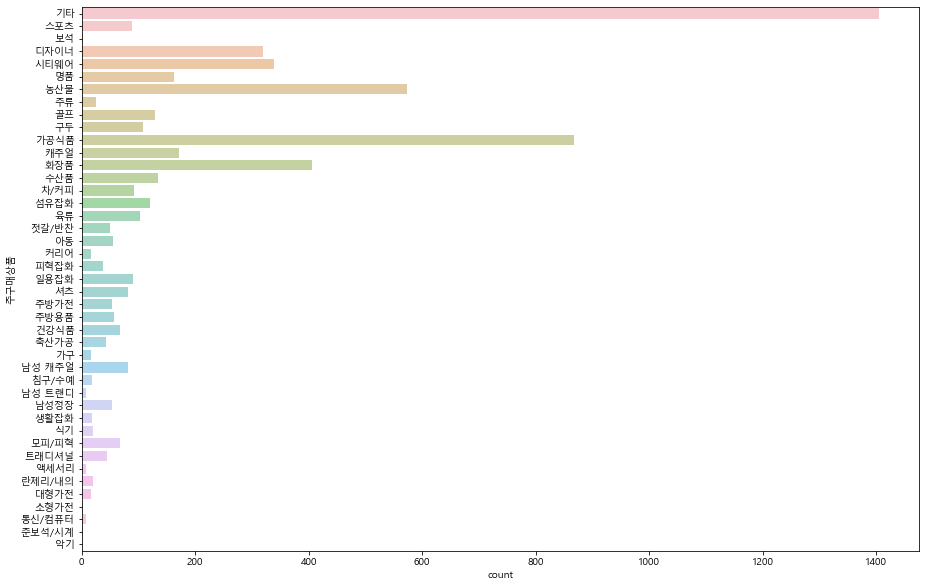

In [16]:
# 범주형 속성 값의 빈도 출력
fig, ax = plt.subplots(figsize=(15, 10))
sns.countplot(y='주구매상품', data=f, alpha=0.5)

**[파생변수 26]** 주구매 지점

In [17]:
f = tr.groupby('cust_id')['store_nm'].agg([
    ('주구매지점', lambda x: x.value_counts().index[0])
]).reset_index()
features = features.merge(f, how='left'); features.head()

,cust_id,총구매액,구매건수,평균구매액,최대구매액,구매상품종류1,구매상품종류2,구매상품종류3,내점일수,구매주기,...,내점당구매액,내점당구매건수,최근3개월_구매금액,최근3개월_구매건수,최근6개월_구매금액,최근6개월_구매건수,최근12개월_구매금액,최근12개월_구매건수,주구매상품,주구매지점
0,0,68282840,74,922741,11264000,35,28,17,19,17,...,3.593834e+06,3.894737,29084140.0,27.0,42601240.0,61.0,68282840,74,기타,강남점
1,1,2136000,3,712000,2136000,2,2,2,2,1,...,1.068000e+06,1.500000,2136000.0,3.0,2136000.0,3.0,2136000,3,스포츠,잠실점
2,2,3197000,4,799250,1639000,1,2,2,2,1,...,1.598500e+06,2.000000,NaN,NaN,NaN,NaN,3197000,4,기타,관악점
3,3,16077620,44,365400,4935000,24,20,13,18,16,...,8.932011e+05,2.444444,549620.0,4.0,1284060.0,11.0,16077620,44,기타,광주점
4,4,29050000,3,9683333,24000000,2,3,3,2,85,...,1.452500e+07,1.500000,27000000.0,2.0,27000000.0,2.0,29050000,3,보석,본 점


**[파생변수 27]** 선호방문계절 - 06

In [18]:
tr['month'] = tr['tran_date'].agg(lambda x: pd.to_datetime(x).month)
tr['season'] = tr['month'].agg(lambda x: 'spring' if x in [3,4,5] else 'summer' if x in [6,7,8]
                              else 'fall' if x in [9,10,11] else 'fall')

In [19]:
f = tr.groupby('cust_id')['season'].agg([
    ('선호방문계절', lambda x: x.value_counts().index[0])
])
features = features.merge(f, on = 'cust_id', how = 'left') ; features.head()

,cust_id,총구매액,구매건수,평균구매액,최대구매액,구매상품종류1,구매상품종류2,구매상품종류3,내점일수,구매주기,...,내점당구매건수,최근3개월_구매금액,최근3개월_구매건수,최근6개월_구매금액,최근6개월_구매건수,최근12개월_구매금액,최근12개월_구매건수,주구매상품,주구매지점,선호방문계절
0,0,68282840,74,922741,11264000,35,28,17,19,17,...,3.894737,29084140.0,27.0,42601240.0,61.0,68282840,74,기타,강남점,fall
1,1,2136000,3,712000,2136000,2,2,2,2,1,...,1.500000,2136000.0,3.0,2136000.0,3.0,2136000,3,스포츠,잠실점,fall
2,2,3197000,4,799250,1639000,1,2,2,2,1,...,2.000000,NaN,NaN,NaN,NaN,3197000,4,기타,관악점,fall
3,3,16077620,44,365400,4935000,24,20,13,18,16,...,2.444444,549620.0,4.0,1284060.0,11.0,16077620,44,기타,광주점,spring
4,4,29050000,3,9683333,24000000,2,3,3,2,85,...,1.500000,27000000.0,2.0,27000000.0,2.0,29050000,3,보석,본 점,fall


**[파생변수 28]** Top-10 베스트 셀러(gds_grp_mclas_nm)에 대한 구매 금액 - 06

In [20]:
top10_bs = tr['gds_grp_mclas_nm'].value_counts().index[:10].to_list()
top10_bs

['기타', '농산물', '가공식품', '축산가공', '수산품', '화장품', '디자이너', '시티웨어', '일용잡화', '육류']

In [21]:
f = tr[tr['gds_grp_mclas_nm'].isin(top10_bs)].groupby('cust_id')['amount'].agg([
    ('top-10베스트셀러_구매금액',np.sum)
])

features = features.merge(f, on = 'cust_id',how = 'left'); features.head()

,cust_id,총구매액,구매건수,평균구매액,최대구매액,구매상품종류1,구매상품종류2,구매상품종류3,내점일수,구매주기,...,최근3개월_구매금액,최근3개월_구매건수,최근6개월_구매금액,최근6개월_구매건수,최근12개월_구매금액,최근12개월_구매건수,주구매상품,주구매지점,선호방문계절,top-10베스트셀러_구매금액
0,0,68282840,74,922741,11264000,35,28,17,19,17,...,29084140.0,27.0,42601240.0,61.0,68282840,74,기타,강남점,fall,45689940.0
1,1,2136000,3,712000,2136000,2,2,2,2,1,...,2136000.0,3.0,2136000.0,3.0,2136000,3,스포츠,잠실점,fall,NaN
2,2,3197000,4,799250,1639000,1,2,2,2,1,...,NaN,NaN,NaN,NaN,3197000,4,기타,관악점,fall,139000.0
3,3,16077620,44,365400,4935000,24,20,13,18,16,...,549620.0,4.0,1284060.0,11.0,16077620,44,기타,광주점,spring,4411020.0
4,4,29050000,3,9683333,24000000,2,3,3,2,85,...,27000000.0,2.0,27000000.0,2.0,29050000,3,보석,본 점,fall,5050000.0


**[파생변수 29]** 주구매요일 - 06

In [22]:
tr['weekday'] = tr['tran_date'].agg(lambda x: pd.to_datetime(x).day_name())

In [23]:
f = tr.groupby('cust_id')['weekday'].agg([
    ('주구매요일', lambda x: x.value_counts().index[0])
])

In [24]:
features = features.merge(f, on = 'cust_id', how = 'left'); features.head()

,cust_id,총구매액,구매건수,평균구매액,최대구매액,구매상품종류1,구매상품종류2,구매상품종류3,내점일수,구매주기,...,최근3개월_구매건수,최근6개월_구매금액,최근6개월_구매건수,최근12개월_구매금액,최근12개월_구매건수,주구매상품,주구매지점,선호방문계절,top-10베스트셀러_구매금액,주구매요일
0,0,68282840,74,922741,11264000,35,28,17,19,17,...,27.0,42601240.0,61.0,68282840,74,기타,강남점,fall,45689940.0,Saturday
1,1,2136000,3,712000,2136000,2,2,2,2,1,...,3.0,2136000.0,3.0,2136000,3,스포츠,잠실점,fall,NaN,Thursday
2,2,3197000,4,799250,1639000,1,2,2,2,1,...,NaN,NaN,NaN,3197000,4,기타,관악점,fall,139000.0,Wednesday
3,3,16077620,44,365400,4935000,24,20,13,18,16,...,4.0,1284060.0,11.0,16077620,44,기타,광주점,spring,4411020.0,Tuesday
4,4,29050000,3,9683333,24000000,2,3,3,2,85,...,2.0,27000000.0,2.0,29050000,3,보석,본 점,fall,5050000.0,Wednesday


**[파생변수 30]** Top-20 베스트 셀러(gds_grp_mclas_nm)에 대한 구매건수 - 07

In [25]:
tr['gds_grp_nm'].value_counts()[0:20]

상품군미지정    69478
농산가공      18693
유제품       13818
일반가공식품    13334
기초 화장품    12921
청과        11196
디자이너부틱    10194
야채         9191
수입식품       8929
유기농야채      8658
햄          7425
밥류         6365
위생세제       5845
시티웨어       5755
생선         5662
니  트       4999
수입단기행사     4874
우육         3830
면류         3760
어덜트        3329
Name: gds_grp_nm, dtype: int64

In [26]:
tr.query('gds_grp_nm == "상품군미지정"')['amount'].reset_index().sort_values(by = 'amount')

,index,amount
51931,62923,-4000000
51436,59996,-3756000
51434,59991,-3756000
10607,59078,-3280000
3278,17348,-3076500
...,...,...
34965,198771,8200000
51661,61083,8400000
24150,135275,8520000
21081,117391,9600000


In [27]:
tr.query('gds_grp_nm == "상품군미지정"')['amount'].describe()

count    6.947800e+04
mean     5.365337e+04
std      2.268655e+05
min     -4.000000e+06
25%      2.500000e+03
50%      8.400000e+03
75%      3.000000e+04
max      1.290000e+07
Name: amount, dtype: float64

- 상품군미지정인 상품들의 가격이 가격의 스펙트럼이 매우 넓어 의미를 가지고 있다고 판단하지 않아 베스트셀러에서 제외

In [28]:
top20 = tr['gds_grp_nm'].value_counts()[1:21].index.tolist()

In [29]:
f = tr.query('gds_grp_nm in @top20').groupby('cust_id')['tran_date'].agg([('top20 구매건수',np.size)]).reset_index()
f

,cust_id,top20 구매건수
0,0,26
1,3,17
2,4,1
3,5,3
4,6,5
...,...,...
4766,5976,17
4767,5977,2
4768,5979,2
4769,5980,6


In [30]:
features = features.merge(f, how='left'); features.head()

,cust_id,총구매액,구매건수,평균구매액,최대구매액,구매상품종류1,구매상품종류2,구매상품종류3,내점일수,구매주기,...,최근6개월_구매금액,최근6개월_구매건수,최근12개월_구매금액,최근12개월_구매건수,주구매상품,주구매지점,선호방문계절,top-10베스트셀러_구매금액,주구매요일,top20 구매건수
0,0,68282840,74,922741,11264000,35,28,17,19,17,...,42601240.0,61.0,68282840,74,기타,강남점,fall,45689940.0,Saturday,26.0
1,1,2136000,3,712000,2136000,2,2,2,2,1,...,2136000.0,3.0,2136000,3,스포츠,잠실점,fall,NaN,Thursday,NaN
2,2,3197000,4,799250,1639000,1,2,2,2,1,...,NaN,NaN,3197000,4,기타,관악점,fall,139000.0,Wednesday,NaN
3,3,16077620,44,365400,4935000,24,20,13,18,16,...,1284060.0,11.0,16077620,44,기타,광주점,spring,4411020.0,Tuesday,17.0
4,4,29050000,3,9683333,24000000,2,3,3,2,85,...,27000000.0,2.0,29050000,3,보석,본 점,fall,5050000.0,Wednesday,1.0


**[파생변수 31]** 구매액 표준편차 - 22

In [31]:
#구매액 표준편차
#가설_여성의 구매액 표준편차는 남성에 비해 높을 것이다.
#식료품은 다른 제품들보다 평균적으로 낮은 금액이므로, 같은 금액을 구매할 때 여성 구매액의 표준편차가 남성보다 더 높을 것이다. 
f = tr.groupby('cust_id')['amount'].agg([('구매액표준편차',np.std)]).reset_index()
features = features.merge(f, how='left');features.head()

,cust_id,총구매액,구매건수,평균구매액,최대구매액,구매상품종류1,구매상품종류2,구매상품종류3,내점일수,구매주기,...,최근6개월_구매건수,최근12개월_구매금액,최근12개월_구매건수,주구매상품,주구매지점,선호방문계절,top-10베스트셀러_구매금액,주구매요일,top20 구매건수,구매액표준편차
0,0,68282840,74,922741,11264000,35,28,17,19,17,...,61.0,68282840,74,기타,강남점,fall,45689940.0,Saturday,26.0,2.019925e+06
1,1,2136000,3,712000,2136000,2,2,2,2,1,...,3.0,2136000,3,스포츠,잠실점,fall,NaN,Thursday,NaN,1.269186e+06
2,2,3197000,4,799250,1639000,1,2,2,2,1,...,NaN,3197000,4,기타,관악점,fall,139000.0,Wednesday,NaN,8.474256e+05
3,3,16077620,44,365400,4935000,24,20,13,18,16,...,11.0,16077620,44,기타,광주점,spring,4411020.0,Tuesday,17.0,9.917303e+05
4,4,29050000,3,9683333,24000000,2,3,3,2,85,...,2.0,29050000,3,보석,본 점,fall,5050000.0,Wednesday,1.0,1.240769e+07


 **[파생변수 32]** 가격선호도 - 분위수를 기준으로 - 06
   - 3분위수 이상 -> '고가'
   - 중위수 이상 -> '중가'
   - 나머지 -> '저가'

In [32]:
tr[['amount']].describe()

,amount
count,3.955620e+05
mean,1.447226e+06
std,6.723928e+06
min,-2.990000e+08
25%,1.580000e+04
50%,9.000000e+04
75%,6.670000e+05
max,7.066290e+08


In [33]:
q75 = tr['amount'].quantile(0.75)
q50 = tr['amount'].quantile(0.5)

In [34]:
amount_mean = tr.groupby('cust_id')[['amount']].mean()
pre = lambda x: '고가' if x > q75 else '중가' if x > q50 else '저가' 
f = amount_mean.amount.apply(pre).reset_index().rename({'amount':'가격선호도'},axis='columns')
f
features = features.merge(f, on = 'cust_id', how = 'left'); features.head()

,cust_id,총구매액,구매건수,평균구매액,최대구매액,구매상품종류1,구매상품종류2,구매상품종류3,내점일수,구매주기,...,최근12개월_구매금액,최근12개월_구매건수,주구매상품,주구매지점,선호방문계절,top-10베스트셀러_구매금액,주구매요일,top20 구매건수,구매액표준편차,가격선호도
0,0,68282840,74,922741,11264000,35,28,17,19,17,...,68282840,74,기타,강남점,fall,45689940.0,Saturday,26.0,2.019925e+06,고가
1,1,2136000,3,712000,2136000,2,2,2,2,1,...,2136000,3,스포츠,잠실점,fall,NaN,Thursday,NaN,1.269186e+06,고가
2,2,3197000,4,799250,1639000,1,2,2,2,1,...,3197000,4,기타,관악점,fall,139000.0,Wednesday,NaN,8.474256e+05,고가
3,3,16077620,44,365400,4935000,24,20,13,18,16,...,16077620,44,기타,광주점,spring,4411020.0,Tuesday,17.0,9.917303e+05,중가
4,4,29050000,3,9683333,24000000,2,3,3,2,85,...,29050000,3,보석,본 점,fall,5050000.0,Wednesday,1.0,1.240769e+07,고가


**[파생변수 33]** 구매지점다양성 - 06

    -고객별 구매지점수를 전체지점수로 나눔 
     1에 가까울수록 다양한 지점에서 구매
     (max : 0.3333, 총24개지점중 8개의 지점이용)

In [35]:
f = tr.groupby('cust_id')['store_nm'].agg([
    ('구매지점수', lambda x: x.nunique())
]).reset_index()
nstore = tr.store_nm.nunique()
f['구매지점다양성'] = f.구매지점수/nstore
features = features.merge(f[['cust_id','구매지점다양성']], on = 'cust_id', how = 'left'); features.head()

,cust_id,총구매액,구매건수,평균구매액,최대구매액,구매상품종류1,구매상품종류2,구매상품종류3,내점일수,구매주기,...,최근12개월_구매건수,주구매상품,주구매지점,선호방문계절,top-10베스트셀러_구매금액,주구매요일,top20 구매건수,구매액표준편차,가격선호도,구매지점다양성
0,0,68282840,74,922741,11264000,35,28,17,19,17,...,74,기타,강남점,fall,45689940.0,Saturday,26.0,2.019925e+06,고가,0.083333
1,1,2136000,3,712000,2136000,2,2,2,2,1,...,3,스포츠,잠실점,fall,NaN,Thursday,NaN,1.269186e+06,고가,0.041667
2,2,3197000,4,799250,1639000,1,2,2,2,1,...,4,기타,관악점,fall,139000.0,Wednesday,NaN,8.474256e+05,고가,0.041667
3,3,16077620,44,365400,4935000,24,20,13,18,16,...,44,기타,광주점,spring,4411020.0,Tuesday,17.0,9.917303e+05,중가,0.041667
4,4,29050000,3,9683333,24000000,2,3,3,2,85,...,3,보석,본 점,fall,5050000.0,Wednesday,1.0,1.240769e+07,고가,0.041667


**[파생변수 34]** 환불비율 - 01

In [36]:
# 총구매건수
f = tr.groupby('cust_id')['amount'].agg([('구매건수', np.size)]).reset_index()

# 환불건수
g = tr[tr.amount < 0].groupby('cust_id')['amount'].agg([('환불건수', np.size)]).reset_index()

f = f.merge(g, how = 'left').fillna(0)
f['환불비율'] = f['환불건수'] / f['구매건수']

features = features.merge(f[['cust_id', '환불비율']], how = 'left'); features.head()

,cust_id,총구매액,구매건수,평균구매액,최대구매액,구매상품종류1,구매상품종류2,구매상품종류3,내점일수,구매주기,...,주구매상품,주구매지점,선호방문계절,top-10베스트셀러_구매금액,주구매요일,top20 구매건수,구매액표준편차,가격선호도,구매지점다양성,환불비율
0,0,68282840,74,922741,11264000,35,28,17,19,17,...,기타,강남점,fall,45689940.0,Saturday,26.0,2.019925e+06,고가,0.083333,0.040541
1,1,2136000,3,712000,2136000,2,2,2,2,1,...,스포츠,잠실점,fall,NaN,Thursday,NaN,1.269186e+06,고가,0.041667,0.333333
2,2,3197000,4,799250,1639000,1,2,2,2,1,...,기타,관악점,fall,139000.0,Wednesday,NaN,8.474256e+05,고가,0.041667,0.000000
3,3,16077620,44,365400,4935000,24,20,13,18,16,...,기타,광주점,spring,4411020.0,Tuesday,17.0,9.917303e+05,중가,0.041667,0.000000
4,4,29050000,3,9683333,24000000,2,3,3,2,85,...,보석,본 점,fall,5050000.0,Wednesday,1.0,1.240769e+07,고가,0.041667,0.000000


**[파생변수 35]** 하루최고구매건수 - 12

In [37]:
datemax = tr.groupby('cust_id')['tran_date'].agg([('하루최고구매건수',
                                                    lambda x:np.max(x.value_counts()))]).reset_index()
features = features.merge(datemax, 'left'); features.head()

,cust_id,총구매액,구매건수,평균구매액,최대구매액,구매상품종류1,구매상품종류2,구매상품종류3,내점일수,구매주기,...,주구매지점,선호방문계절,top-10베스트셀러_구매금액,주구매요일,top20 구매건수,구매액표준편차,가격선호도,구매지점다양성,환불비율,하루최고구매건수
0,0,68282840,74,922741,11264000,35,28,17,19,17,...,강남점,fall,45689940.0,Saturday,26.0,2.019925e+06,고가,0.083333,0.040541,10
1,1,2136000,3,712000,2136000,2,2,2,2,1,...,잠실점,fall,NaN,Thursday,NaN,1.269186e+06,고가,0.041667,0.333333,2
2,2,3197000,4,799250,1639000,1,2,2,2,1,...,관악점,fall,139000.0,Wednesday,NaN,8.474256e+05,고가,0.041667,0.000000,2
3,3,16077620,44,365400,4935000,24,20,13,18,16,...,광주점,spring,4411020.0,Tuesday,17.0,9.917303e+05,중가,0.041667,0.000000,8
4,4,29050000,3,9683333,24000000,2,3,3,2,85,...,본 점,fall,5050000.0,Wednesday,1.0,1.240769e+07,고가,0.041667,0.000000,2


**[파생변수 36]** 휴일방문비율(명절 등등) - 07

: 일반적으로 남성이 평일대비 휴일 방문율이 높을 것이라고 판단하여 피쳐 생성
- https://www.trendmonitor.co.kr/tmweb/trend/allTrend/detail.do?bIdx=1199&code=0201&trendType=CKOREA
- 2007년 주말을 제외한 휴일
- : 20070101, 20070219, 20070301, 20070524, 20070606, 20070815, 20070924, 20070925, 20070926, 20071003, 20071009, 20071225

In [38]:
tr['holiday1'] = tr['weekday'].agg(lambda x : 1 if x in ['Sunday', 'Saturday']
                                   else 0)
tr['holiday2'] = tr['tran_date'].agg(lambda x : 1 if str(x)[:10] in ['2007-01-01', '2007-02-19', '2007-03-01', '2007-05-24', '2007-06-06', '2007-08-15', '2007-09-24', '2007-09-25', '2007-09-26', '2007-10-03', '2007-10-09', '2007-12-25']
                               else 0)
tr['holiday'] = tr['holiday1'] + tr['holiday2']
tr['holiday'] = np.where(tr['holiday'] == 2, 1, tr['holiday'])
tr = tr.drop(['holiday1', 'holiday2'], axis='columns')

f = tr.groupby('cust_id')['holiday'].agg([('휴일방문율', lambda x : (x.sum()/ len(x)).round(3))]).reset_index()
features = features.merge(f, how='left', on = 'cust_id'); features.head()

,cust_id,총구매액,구매건수,평균구매액,최대구매액,구매상품종류1,구매상품종류2,구매상품종류3,내점일수,구매주기,...,선호방문계절,top-10베스트셀러_구매금액,주구매요일,top20 구매건수,구매액표준편차,가격선호도,구매지점다양성,환불비율,하루최고구매건수,휴일방문율
0,0,68282840,74,922741,11264000,35,28,17,19,17,...,fall,45689940.0,Saturday,26.0,2.019925e+06,고가,0.083333,0.040541,10,0.568
1,1,2136000,3,712000,2136000,2,2,2,2,1,...,fall,NaN,Thursday,NaN,1.269186e+06,고가,0.041667,0.333333,2,0.000
2,2,3197000,4,799250,1639000,1,2,2,2,1,...,fall,139000.0,Wednesday,NaN,8.474256e+05,고가,0.041667,0.000000,2,0.000
3,3,16077620,44,365400,4935000,24,20,13,18,16,...,spring,4411020.0,Tuesday,17.0,9.917303e+05,중가,0.041667,0.000000,8,0.386
4,4,29050000,3,9683333,24000000,2,3,3,2,85,...,fall,5050000.0,Wednesday,1.0,1.240769e+07,고가,0.041667,0.000000,2,0.000


**[파생변수 37]** 고객등급 - 28

In [39]:
features['고객등급'] = features['총구매액'].apply(lambda x: 'BABY' if x < 20000000
                                     else 'VIP' if x < 50000000
                                     else 'VIP+' if x < 90000000
                                     else 'ACE' if x < 200000000
                                     else 'CROWN' if x < 500000000
                                     else 'PRESTIGE' if x < 750000000
                                     else 'LENITH')
features.head()

,cust_id,총구매액,구매건수,평균구매액,최대구매액,구매상품종류1,구매상품종류2,구매상품종류3,내점일수,구매주기,...,top-10베스트셀러_구매금액,주구매요일,top20 구매건수,구매액표준편차,가격선호도,구매지점다양성,환불비율,하루최고구매건수,휴일방문율,고객등급
0,0,68282840,74,922741,11264000,35,28,17,19,17,...,45689940.0,Saturday,26.0,2.019925e+06,고가,0.083333,0.040541,10,0.568,VIP+
1,1,2136000,3,712000,2136000,2,2,2,2,1,...,NaN,Thursday,NaN,1.269186e+06,고가,0.041667,0.333333,2,0.000,BABY
2,2,3197000,4,799250,1639000,1,2,2,2,1,...,139000.0,Wednesday,NaN,8.474256e+05,고가,0.041667,0.000000,2,0.000,BABY
3,3,16077620,44,365400,4935000,24,20,13,18,16,...,4411020.0,Tuesday,17.0,9.917303e+05,중가,0.041667,0.000000,8,0.386,BABY
4,4,29050000,3,9683333,24000000,2,3,3,2,85,...,5050000.0,Wednesday,1.0,1.240769e+07,고가,0.041667,0.000000,2,0.000,VIP


**[파생변수 38]** 요일간 구매건수 편차 - 07

: 요일별로 전체 구매건수로 나눈 후 가장 높은 요일과 가장 낮은 요일의 차이를 계산하여 편차를 계산

In [40]:
f = pd.pivot_table(tr, index = 'cust_id', columns = 'weekday', values = 'amount', aggfunc = ['count'])
f1 = f.transpose()/f.transpose().sum()
f = f1.transpose()
f = f.fillna(0)

f2 = np.apply_along_axis(lambda x: np.max(x) - np.min(x), 1, f)

In [41]:
features = pd.concat((features, pd.DataFrame(f2)), axis = 1)

In [42]:
features = features.rename({0:'요일 간 구매건수 편차'}, axis = 'columns');features.head()

,cust_id,총구매액,구매건수,평균구매액,최대구매액,구매상품종류1,구매상품종류2,구매상품종류3,내점일수,구매주기,...,주구매요일,top20 구매건수,구매액표준편차,가격선호도,구매지점다양성,환불비율,하루최고구매건수,휴일방문율,고객등급,요일 간 구매건수 편차
0,0,68282840,74,922741,11264000,35,28,17,19,17,...,Saturday,26.0,2.019925e+06,고가,0.083333,0.040541,10,0.568,VIP+,0.337838
1,1,2136000,3,712000,2136000,2,2,2,2,1,...,Thursday,NaN,1.269186e+06,고가,0.041667,0.333333,2,0.000,BABY,0.666667
2,2,3197000,4,799250,1639000,1,2,2,2,1,...,Wednesday,NaN,8.474256e+05,고가,0.041667,0.000000,2,0.000,BABY,0.500000
3,3,16077620,44,365400,4935000,24,20,13,18,16,...,Tuesday,17.0,9.917303e+05,중가,0.041667,0.000000,8,0.386,BABY,0.181818
4,4,29050000,3,9683333,24000000,2,3,3,2,85,...,Wednesday,1.0,1.240769e+07,고가,0.041667,0.000000,2,0.000,VIP,0.666667


**[파생변수 39]** 재구매율 - 07

In [43]:
f = pd.pivot_table(tr, index = 'cust_id', columns = 'gds_grp_nm', values = 'tran_date',aggfunc = 'count')

In [44]:
f = f.fillna(0)

In [45]:
f['재구매횟수'] = f.apply(lambda x: x>=2).sum(axis = 1)

In [46]:
f1 = f['재구매횟수']/features['구매건수']

In [47]:
features = pd.concat([features,f1], axis = 1)

In [48]:
features = features.rename({0:'재구매비율'}, axis = 'columns'); features.head()

,cust_id,총구매액,구매건수,평균구매액,최대구매액,구매상품종류1,구매상품종류2,구매상품종류3,내점일수,구매주기,...,top20 구매건수,구매액표준편차,가격선호도,구매지점다양성,환불비율,하루최고구매건수,휴일방문율,고객등급,요일 간 구매건수 편차,재구매비율
0,0,68282840,74,922741,11264000,35,28,17,19,17,...,26.0,2.019925e+06,고가,0.083333,0.040541,10,0.568,VIP+,0.337838,0.202703
1,1,2136000,3,712000,2136000,2,2,2,2,1,...,NaN,1.269186e+06,고가,0.041667,0.333333,2,0.000,BABY,0.666667,0.333333
2,2,3197000,4,799250,1639000,1,2,2,2,1,...,NaN,8.474256e+05,고가,0.041667,0.000000,2,0.000,BABY,0.500000,0.500000
3,3,16077620,44,365400,4935000,24,20,13,18,16,...,17.0,9.917303e+05,중가,0.041667,0.000000,8,0.386,BABY,0.181818,0.204545
4,4,29050000,3,9683333,24000000,2,3,3,2,85,...,1.0,1.240769e+07,고가,0.041667,0.000000,2,0.000,VIP,0.666667,0.000000


**[파생변수 40]** 충동지수(내점당 구매액/총구매액) - 10

In [49]:
features["충동지수"] = features["내점당구매액"]/features["총구매액"]

features.head()

,cust_id,총구매액,구매건수,평균구매액,최대구매액,구매상품종류1,구매상품종류2,구매상품종류3,내점일수,구매주기,...,구매액표준편차,가격선호도,구매지점다양성,환불비율,하루최고구매건수,휴일방문율,고객등급,요일 간 구매건수 편차,재구매비율,충동지수
0,0,68282840,74,922741,11264000,35,28,17,19,17,...,2.019925e+06,고가,0.083333,0.040541,10,0.568,VIP+,0.337838,0.202703,0.052632
1,1,2136000,3,712000,2136000,2,2,2,2,1,...,1.269186e+06,고가,0.041667,0.333333,2,0.000,BABY,0.666667,0.333333,0.500000
2,2,3197000,4,799250,1639000,1,2,2,2,1,...,8.474256e+05,고가,0.041667,0.000000,2,0.000,BABY,0.500000,0.500000,0.500000
3,3,16077620,44,365400,4935000,24,20,13,18,16,...,9.917303e+05,중가,0.041667,0.000000,8,0.386,BABY,0.181818,0.204545,0.055556
4,4,29050000,3,9683333,24000000,2,3,3,2,85,...,1.240769e+07,고가,0.041667,0.000000,2,0.000,VIP,0.666667,0.000000,0.500000


**[파생변수 41]** 단독 상품군 구매율 - 16

In [50]:
tr_cbynm = tr.groupby(['cust_id','gds_grp_mclas_nm'])['amount'].agg([('구매건수', np.size)]).reset_index()
tr_cbynm.query("구매건수 == 1")

,cust_id,gds_grp_mclas_nm,구매건수
0,0,가공식품,1
2,0,골프,1
4,0,남성정장,1
9,0,셔츠,1
14,0,젓갈/반찬,1
...,...,...,...
60658,5980,구두,1
60659,5980,수산품,1
60662,5980,침구/수예,1
60665,5981,차/커피,1


In [51]:
f = tr.groupby('cust_id')['amount'].agg([('구매건수', np.size)])
f2 = tr_cbynm.query("구매건수 == 1").groupby('cust_id')['구매건수'].agg([('단독상품군구매수', np.sum)]).reset_index()

f = pd.merge(f,f2, on = 'cust_id', how='left').fillna(0)
f['단독상품군구매율'] = f['단독상품군구매수']/f['구매건수']
f.head()

,cust_id,구매건수,단독상품군구매수,단독상품군구매율
0,0,74,5.0,0.067568
1,1,3,1.0,0.333333
2,2,4,0.0,0.000000
3,3,44,5.0,0.113636
4,4,3,3.0,1.000000


In [52]:
f = f[['cust_id','단독상품군구매율']]
features = features.merge(f,on='cust_id', how='left'); features.head()

,cust_id,총구매액,구매건수,평균구매액,최대구매액,구매상품종류1,구매상품종류2,구매상품종류3,내점일수,구매주기,...,가격선호도,구매지점다양성,환불비율,하루최고구매건수,휴일방문율,고객등급,요일 간 구매건수 편차,재구매비율,충동지수,단독상품군구매율
0,0,68282840,74,922741,11264000,35,28,17,19,17,...,고가,0.083333,0.040541,10,0.568,VIP+,0.337838,0.202703,0.052632,0.067568
1,1,2136000,3,712000,2136000,2,2,2,2,1,...,고가,0.041667,0.333333,2,0.000,BABY,0.666667,0.333333,0.500000,0.333333
2,2,3197000,4,799250,1639000,1,2,2,2,1,...,고가,0.041667,0.000000,2,0.000,BABY,0.500000,0.500000,0.500000,0.000000
3,3,16077620,44,365400,4935000,24,20,13,18,16,...,중가,0.041667,0.000000,8,0.386,BABY,0.181818,0.204545,0.055556,0.113636
4,4,29050000,3,9683333,24000000,2,3,3,2,85,...,고가,0.041667,0.000000,2,0.000,VIP,0.666667,0.000000,0.500000,1.000000


**[파생변수 42]** 내점당 평균구매상품종류 - 19

In [53]:
visits = tr.groupby('cust_id')['tran_date'].agg(lambda x: x.nunique())

f = (tr.groupby('cust_id')['gds_grp_mclas_nm'].nunique() / visits).reset_index().rename(columns={0 : '내점당평균구매상품종류'})

features = features.merge(f, how='left'); features.head()

,cust_id,총구매액,구매건수,평균구매액,최대구매액,구매상품종류1,구매상품종류2,구매상품종류3,내점일수,구매주기,...,구매지점다양성,환불비율,하루최고구매건수,휴일방문율,고객등급,요일 간 구매건수 편차,재구매비율,충동지수,단독상품군구매율,내점당평균구매상품종류
0,0,68282840,74,922741,11264000,35,28,17,19,17,...,0.083333,0.040541,10,0.568,VIP+,0.337838,0.202703,0.052632,0.067568,0.894737
1,1,2136000,3,712000,2136000,2,2,2,2,1,...,0.041667,0.333333,2,0.000,BABY,0.666667,0.333333,0.500000,0.333333,1.000000
2,2,3197000,4,799250,1639000,1,2,2,2,1,...,0.041667,0.000000,2,0.000,BABY,0.500000,0.500000,0.500000,0.000000,1.000000
3,3,16077620,44,365400,4935000,24,20,13,18,16,...,0.041667,0.000000,8,0.386,BABY,0.181818,0.204545,0.055556,0.113636,0.722222
4,4,29050000,3,9683333,24000000,2,3,3,2,85,...,0.041667,0.000000,2,0.000,VIP,0.666667,0.000000,0.500000,1.000000,1.500000


**[파생변수 43]** 구매력지수 - 19

In [54]:
tr.groupby(['cust_id','tran_date'])['amount'].agg(np.max).reset_index().head()

#두개의 column 을 대상으로 groupby를 진행, 각 구매일의 최대구매금액을 먼저 계산한 후

,cust_id,tran_date,amount
0,0,2007-01-19 00:00:00,850000
1,0,2007-03-30 00:00:00,3000000
2,0,2007-05-13 00:00:00,11264000
3,0,2007-06-09 00:00:00,2677200
4,0,2007-07-08 00:00:00,3850000


In [55]:
f = tr.groupby(['cust_id','tran_date'])['amount'].agg(np.max).reset_index().groupby('cust_id')['amount'].agg([
    ('구매력지수', lambda x : np.mean(x))]).reset_index()

#이를 다시 cust_id와 amount만을 이용하여  내점당 최대구매금액평균을 구했다.

In [56]:
f = f.구매력지수.astype(int).reset_index()
f = f.rename(columns = {'index' : 'cust_id'})
features = features.merge(f, how='left'); features.head()

,cust_id,총구매액,구매건수,평균구매액,최대구매액,구매상품종류1,구매상품종류2,구매상품종류3,내점일수,구매주기,...,환불비율,하루최고구매건수,휴일방문율,고객등급,요일 간 구매건수 편차,재구매비율,충동지수,단독상품군구매율,내점당평균구매상품종류,구매력지수
0,0,68282840,74,922741,11264000,35,28,17,19,17,...,0.040541,10,0.568,VIP+,0.337838,0.202703,0.052632,0.067568,0.894737,2713656
1,1,2136000,3,712000,2136000,2,2,2,2,1,...,0.333333,2,0.000,BABY,0.666667,0.333333,0.500000,0.333333,1.000000,1218000
2,2,3197000,4,799250,1639000,1,2,2,2,1,...,0.000000,2,0.000,BABY,0.500000,0.500000,0.500000,0.000000,1.000000,1529000
3,3,16077620,44,365400,4935000,24,20,13,18,16,...,0.000000,8,0.386,BABY,0.181818,0.204545,0.055556,0.113636,0.722222,782031
4,4,29050000,3,9683333,24000000,2,3,3,2,85,...,0.000000,2,0.000,VIP,0.666667,0.000000,0.500000,1.000000,1.500000,13025000


**[파생변수 44]** 최소구매액 - 07

: 여성이 식료품과 같이 금액단위가 작은 상품들을 구매는 경우가 많기 때문에 피쳐로 채택 (amount가음수인 환불금액은 제외)

In [57]:
f = tr.query('amount>0').groupby('cust_id')['amount'].agg([
    ('최소구매액', np.min)
]).reset_index()
features = features.merge(f, how='left').fillna(0) ;features.head()

,cust_id,총구매액,구매건수,평균구매액,최대구매액,구매상품종류1,구매상품종류2,구매상품종류3,내점일수,구매주기,...,하루최고구매건수,휴일방문율,고객등급,요일 간 구매건수 편차,재구매비율,충동지수,단독상품군구매율,내점당평균구매상품종류,구매력지수,최소구매액
0,0,68282840,74,922741,11264000,35,28,17,19,17,...,10,0.568,VIP+,0.337838,0.202703,0.052632,0.067568,0.894737,2713656,1150.0
1,1,2136000,3,712000,2136000,2,2,2,2,1,...,2,0.000,BABY,0.666667,0.333333,0.500000,0.333333,1.000000,1218000,300000.0
2,2,3197000,4,799250,1639000,1,2,2,2,1,...,2,0.000,BABY,0.500000,0.500000,0.500000,0.000000,1.000000,1529000,64500.0
3,3,16077620,44,365400,4935000,24,20,13,18,16,...,8,0.386,BABY,0.181818,0.204545,0.055556,0.113636,0.722222,782031,1800.0
4,4,29050000,3,9683333,24000000,2,3,3,2,85,...,2,0.000,VIP,0.666667,0.000000,0.500000,1.000000,1.500000,13025000,2050000.0


**[파생변수 45]** 구매요일 변동계수 - 23

- 요일별 구매 변동사항이 적음(변동계수가 적을수록)
- 요일별 구매 변동사항이 적으면 여성이라고 판단(여성들이 구매 방문 자주 할것이라 판단)

In [58]:
tr['tran_date'] = tr.tran_date.astype('datetime64')
tr['date'] = tr.tran_date.apply(lambda x : x.weekday())
tr['month'] = tr.tran_date.apply(lambda x : x.month)

day = pd.pivot_table(tr, index = 'cust_id', columns = 'date', values= 'amount', fill_value = 0, aggfunc = 'count')
display(day)  # 요일별 구매 횟수
day_mean = day.apply(lambda x: x.mean(), axis=1)   # cust_id별 구매 평균(요일)
day_std = day.apply(lambda x: x.std(), axis =1)  # cust_id별 구매 표준편차(요일)
f = (day_std/day_mean).reset_index().rename(columns = {0 : '요일_변동계수'})
features = pd.merge(features, f, how = 'left');features.head()

date,0,1,2,3,4,5,6
cust_id,,,,,,,
0,6,2,12,6,9,27,12
1,1,0,0,2,0,0,0
2,2,0,2,0,0,0,0
3,5,11,6,5,3,9,5
4,1,0,2,0,0,0,0
...,...,...,...,...,...,...,...
5977,0,1,0,1,3,7,2
5978,1,0,0,0,0,0,0
5979,0,3,3,0,0,0,65


,cust_id,총구매액,구매건수,평균구매액,최대구매액,구매상품종류1,구매상품종류2,구매상품종류3,내점일수,구매주기,...,휴일방문율,고객등급,요일 간 구매건수 편차,재구매비율,충동지수,단독상품군구매율,내점당평균구매상품종류,구매력지수,최소구매액,요일_변동계수
0,0,68282840,74,922741,11264000,35,28,17,19,17,...,0.568,VIP+,0.337838,0.202703,0.052632,0.067568,0.894737,2713656,1150.0,0.764320
1,1,2136000,3,712000,2136000,2,2,2,2,1,...,0.000,BABY,0.666667,0.333333,0.500000,0.333333,1.000000,1218000,300000.0,1.835857
2,2,3197000,4,799250,1639000,1,2,2,2,1,...,0.000,BABY,0.500000,0.500000,0.500000,0.000000,1.000000,1529000,64500.0,1.707825
3,3,16077620,44,365400,4935000,24,20,13,18,16,...,0.386,BABY,0.181818,0.204545,0.055556,0.113636,0.722222,782031,1800.0,0.437758
4,4,29050000,3,9683333,24000000,2,3,3,2,85,...,0.000,VIP,0.666667,0.000000,0.500000,1.000000,1.500000,13025000,2050000.0,1.835857


**[파생변수 46]** 거래당 구매 물품 다양성 - 27

In [59]:
n = tr.gds_grp_mclas_nm.nunique()
d = pd.DataFrame(tr.groupby(['cust_id','tran_date'])['gds_grp_mclas_nm'].count()/n)
f = d.groupby('cust_id')['gds_grp_mclas_nm'].agg([('거래당 구매 물품 다양성','mean')])
features = features.merge(f,on='cust_id', how='left'); features.head()

,cust_id,총구매액,구매건수,평균구매액,최대구매액,구매상품종류1,구매상품종류2,구매상품종류3,내점일수,구매주기,...,고객등급,요일 간 구매건수 편차,재구매비율,충동지수,단독상품군구매율,내점당평균구매상품종류,구매력지수,최소구매액,요일_변동계수,거래당 구매 물품 다양성
0,0,68282840,74,922741,11264000,35,28,17,19,17,...,VIP+,0.337838,0.202703,0.052632,0.067568,0.894737,2713656,1150.0,0.764320,0.079484
1,1,2136000,3,712000,2136000,2,2,2,2,1,...,BABY,0.666667,0.333333,0.500000,0.333333,1.000000,1218000,300000.0,1.835857,0.030612
2,2,3197000,4,799250,1639000,1,2,2,2,1,...,BABY,0.500000,0.500000,0.500000,0.000000,1.000000,1529000,64500.0,1.707825,0.040816
3,3,16077620,44,365400,4935000,24,20,13,18,16,...,BABY,0.181818,0.204545,0.055556,0.113636,0.722222,782031,1800.0,0.437758,0.049887
4,4,29050000,3,9683333,24000000,2,3,3,2,85,...,VIP,0.666667,0.000000,0.500000,1.000000,1.500000,13025000,2050000.0,1.835857,0.030612


**[파생변수 47]** 시즌마감방문비율 - 31

In [60]:
def season(x):
    m = x.month
    d = x.day
    if 21<= d <= 31 and 3<= m <= 5:
        return('봄 시즌 마감')
    elif 21<= d <= 31 and 6<= m <=8:
        return('여름 시즌 마감')
    elif 21<= d <= 31 and 9<= m <=11:
        return('가을 시즌 마감')
    elif 21<= d <= 31 and (12 == m or m <=2):
        return('겨울 시즌 마감')
    else :
        return('그 외')    
    

In [61]:
tr['season_sale'] = pd.to_datetime(tr.tran_date).apply(season)
f = pd.pivot_table(tr, index='cust_id', columns='season_sale', values='amount', 
                   aggfunc=np.size, fill_value=0).reset_index()
af = pd.DataFrame(f['봄 시즌 마감']+f['여름 시즌 마감']+f['가을 시즌 마감']+f['겨울 시즌 마감']).reset_index()
af = af.rename({'index':'cust_id',0:'시즌 마감'},axis=1)
ss = pd.DataFrame(af['시즌 마감']/features['내점일수']).reset_index()
ss = ss.rename({'index':'cust_id',0:'시즌 마감 방문비율'},axis=1)
features = features.merge(ss,on='cust_id', how='left'); features.head()

,cust_id,총구매액,구매건수,평균구매액,최대구매액,구매상품종류1,구매상품종류2,구매상품종류3,내점일수,구매주기,...,요일 간 구매건수 편차,재구매비율,충동지수,단독상품군구매율,내점당평균구매상품종류,구매력지수,최소구매액,요일_변동계수,거래당 구매 물품 다양성,시즌 마감 방문비율
0,0,68282840,74,922741,11264000,35,28,17,19,17,...,0.337838,0.202703,0.052632,0.067568,0.894737,2713656,1150.0,0.764320,0.079484,0.684211
1,1,2136000,3,712000,2136000,2,2,2,2,1,...,0.666667,0.333333,0.500000,0.333333,1.000000,1218000,300000.0,1.835857,0.030612,1.500000
2,2,3197000,4,799250,1639000,1,2,2,2,1,...,0.500000,0.500000,0.500000,0.000000,1.000000,1529000,64500.0,1.707825,0.040816,0.000000
3,3,16077620,44,365400,4935000,24,20,13,18,16,...,0.181818,0.204545,0.055556,0.113636,0.722222,782031,1800.0,0.437758,0.049887,0.833333
4,4,29050000,3,9683333,24000000,2,3,3,2,85,...,0.666667,0.000000,0.500000,1.000000,1.500000,13025000,2050000.0,1.835857,0.030612,0.500000


**[파생변수 48]** 고가상품최다빈도품목 - 28

In [62]:
#상위 25%의 고가상품 중 가장 빈도가 높은 품목
Q1 = tr['amount'].quantile(0.25)
Q2 = tr['amount'].quantile(0.5)
Q3 = tr['amount'].quantile(0.75)
Q4 = tr['amount'].quantile(1.0)

In [63]:
tr['amount_quarter'] = tr['amount'].apply(lambda x: 'amount_1' if x <= Q1
                          else ('amount_2' if Q1 < x <= Q2
                               else ('amount_3' if Q2 < x <= Q3 
                                     else 'amount_4')))

In [64]:
f = tr.query('amount_quarter =="amount_4"') ; f.head()

,cust_id,tran_date,store_nm,goods_id,gds_grp_nm,gds_grp_mclas_nm,amount,month,season,weekday,holiday,date,season_sale,amount_quarter
0,0,2007-01-19,강남점,127105,기초 화장품,화장품,850000,1,fall,Friday,0,4,그 외,amount_4
2,0,2007-03-30,강남점,127105,기초 화장품,화장품,3000000,3,spring,Friday,0,4,봄 시즌 마감,amount_4
3,0,2007-03-30,강남점,342205,니 트,시티웨어,840000,3,spring,Friday,0,4,봄 시즌 마감,amount_4
5,0,2007-05-13,강남점,127105,기초 화장품,화장품,3000000,5,spring,Sunday,1,6,그 외,amount_4
6,0,2007-05-13,강남점,321101,디자이너부틱,디자이너,11264000,5,spring,Sunday,1,6,그 외,amount_4


In [65]:
f = f.groupby('cust_id')['gds_grp_mclas_nm'].agg([('고가상품최다빈도품목',lambda x: x.value_counts().index[0])]).reset_index()
f.head()

,cust_id,고가상품최다빈도품목
0,0,화장품
1,1,트래디셔널
2,2,남성 캐주얼
3,3,구두
4,4,보석


In [66]:
features = pd.merge(left = features, right = f, how='left', on = 'cust_id') ;features.head()

,cust_id,총구매액,구매건수,평균구매액,최대구매액,구매상품종류1,구매상품종류2,구매상품종류3,내점일수,구매주기,...,재구매비율,충동지수,단독상품군구매율,내점당평균구매상품종류,구매력지수,최소구매액,요일_변동계수,거래당 구매 물품 다양성,시즌 마감 방문비율,고가상품최다빈도품목
0,0,68282840,74,922741,11264000,35,28,17,19,17,...,0.202703,0.052632,0.067568,0.894737,2713656,1150.0,0.764320,0.079484,0.684211,화장품
1,1,2136000,3,712000,2136000,2,2,2,2,1,...,0.333333,0.500000,0.333333,1.000000,1218000,300000.0,1.835857,0.030612,1.500000,트래디셔널
2,2,3197000,4,799250,1639000,1,2,2,2,1,...,0.500000,0.500000,0.000000,1.000000,1529000,64500.0,1.707825,0.040816,0.000000,남성 캐주얼
3,3,16077620,44,365400,4935000,24,20,13,18,16,...,0.204545,0.055556,0.113636,0.722222,782031,1800.0,0.437758,0.049887,0.833333,구두
4,4,29050000,3,9683333,24000000,2,3,3,2,85,...,0.000000,0.500000,1.000000,1.500000,13025000,2050000.0,1.835857,0.030612,0.500000,보석


**[파생변수 49]** 최대지출품목 - 28

In [67]:
p = pd.pivot_table(tr, index = 'cust_id', columns = 'gds_grp_mclas_nm', values = 'amount', aggfunc =  np.sum)
p = p.fillna(0)
p['최대지출품목'] = p.idxmax(axis=1)
p = p['최대지출품목'].reset_index();p.head()

,cust_id,최대지출품목
0,0,화장품
1,1,트래디셔널
2,2,남성 캐주얼
3,3,침구/수예
4,4,보석


In [68]:
features = features.merge(p, how='left'); features.head()

,cust_id,총구매액,구매건수,평균구매액,최대구매액,구매상품종류1,구매상품종류2,구매상품종류3,내점일수,구매주기,...,충동지수,단독상품군구매율,내점당평균구매상품종류,구매력지수,최소구매액,요일_변동계수,거래당 구매 물품 다양성,시즌 마감 방문비율,고가상품최다빈도품목,최대지출품목
0,0,68282840,74,922741,11264000,35,28,17,19,17,...,0.052632,0.067568,0.894737,2713656,1150.0,0.764320,0.079484,0.684211,화장품,화장품
1,1,2136000,3,712000,2136000,2,2,2,2,1,...,0.500000,0.333333,1.000000,1218000,300000.0,1.835857,0.030612,1.500000,트래디셔널,트래디셔널
2,2,3197000,4,799250,1639000,1,2,2,2,1,...,0.500000,0.000000,1.000000,1529000,64500.0,1.707825,0.040816,0.000000,남성 캐주얼,남성 캐주얼
3,3,16077620,44,365400,4935000,24,20,13,18,16,...,0.055556,0.113636,0.722222,782031,1800.0,0.437758,0.049887,0.833333,구두,침구/수예
4,4,29050000,3,9683333,24000000,2,3,3,2,85,...,0.500000,1.000000,1.500000,13025000,2050000.0,1.835857,0.030612,0.500000,보석,보석


**[파생변수 50]** 저가상품구매비율 - 07

: 여성이 남성보다 상대적으로 식료품을 많이 산다고 판단하여 피쳐로 채택

In [69]:
price_4q = tr.groupby('goods_id')['amount'].mean().quantile([.25,.5,.75])
price_4q

0.25    7.876190e+04
0.50    4.160000e+05
0.75    1.565667e+06
Name: amount, dtype: float64

In [70]:
f = (tr.groupby('cust_id')['amount']
     .agg([('저가상품구매율', lambda x: (x < price_4q.iloc[0]).mean().round(2))])
     .reset_index())
f.head()

,cust_id,저가상품구매율
0,0,0.43
1,1,0.33
2,2,0.50
3,3,0.50
4,4,0.00


In [71]:
features = features.merge(f, how='left');features.head()

,cust_id,총구매액,구매건수,평균구매액,최대구매액,구매상품종류1,구매상품종류2,구매상품종류3,내점일수,구매주기,...,단독상품군구매율,내점당평균구매상품종류,구매력지수,최소구매액,요일_변동계수,거래당 구매 물품 다양성,시즌 마감 방문비율,고가상품최다빈도품목,최대지출품목,저가상품구매율
0,0,68282840,74,922741,11264000,35,28,17,19,17,...,0.067568,0.894737,2713656,1150.0,0.764320,0.079484,0.684211,화장품,화장품,0.43
1,1,2136000,3,712000,2136000,2,2,2,2,1,...,0.333333,1.000000,1218000,300000.0,1.835857,0.030612,1.500000,트래디셔널,트래디셔널,0.33
2,2,3197000,4,799250,1639000,1,2,2,2,1,...,0.000000,1.000000,1529000,64500.0,1.707825,0.040816,0.000000,남성 캐주얼,남성 캐주얼,0.50
3,3,16077620,44,365400,4935000,24,20,13,18,16,...,0.113636,0.722222,782031,1800.0,0.437758,0.049887,0.833333,구두,침구/수예,0.50
4,4,29050000,3,9683333,24000000,2,3,3,2,85,...,1.000000,1.500000,13025000,2050000.0,1.835857,0.030612,0.500000,보석,보석,0.00


**[파생변수 51]** 고가상품구매비율 - 07

: 남성은 백화점에서 여성에 비해 고가상품구매비율이 높을것이라고 판단하여 피쳐로 채택

In [72]:
f = (tr.groupby('cust_id')['amount']
     .agg([('고가상품구매율', lambda x: (x > price_4q.iloc[2]).mean().round(2))])
     .reset_index())
f.head()

,cust_id,고가상품구매율
0,0,0.20
1,1,0.33
2,2,0.25
3,3,0.05
4,4,1.00


In [73]:
features = features.merge(f, how='left');features.head()

,cust_id,총구매액,구매건수,평균구매액,최대구매액,구매상품종류1,구매상품종류2,구매상품종류3,내점일수,구매주기,...,내점당평균구매상품종류,구매력지수,최소구매액,요일_변동계수,거래당 구매 물품 다양성,시즌 마감 방문비율,고가상품최다빈도품목,최대지출품목,저가상품구매율,고가상품구매율
0,0,68282840,74,922741,11264000,35,28,17,19,17,...,0.894737,2713656,1150.0,0.764320,0.079484,0.684211,화장품,화장품,0.43,0.20
1,1,2136000,3,712000,2136000,2,2,2,2,1,...,1.000000,1218000,300000.0,1.835857,0.030612,1.500000,트래디셔널,트래디셔널,0.33,0.33
2,2,3197000,4,799250,1639000,1,2,2,2,1,...,1.000000,1529000,64500.0,1.707825,0.040816,0.000000,남성 캐주얼,남성 캐주얼,0.50,0.25
3,3,16077620,44,365400,4935000,24,20,13,18,16,...,0.722222,782031,1800.0,0.437758,0.049887,0.833333,구두,침구/수예,0.50,0.05
4,4,29050000,3,9683333,24000000,2,3,3,2,85,...,1.500000,13025000,2050000.0,1.835857,0.030612,0.500000,보석,보석,0.00,1.00


**[파생변수 52]** 요일별 구매추세 - 23
> 값이 높을 수록 주말의 구매가 많음

> 가설: 주말의 구매추세가 높을 수록 남성일 확률이 크다고 가설(그렇게 사유한 이유: 남성들이 주말의 방문확률이 크다고 생각)
 + 구매 추세가 거의 0에 가까워도 남성이라고 판단

In [74]:
tr['date'] = tr.tran_date.apply(lambda x : x.weekday())

day_to = tr.tran_date.dt.weekday.max()
day_trans = []
for i in range(7):
    day_from = day_to - 1
    day_trans.append(tr.query('@day_from < date <= @day_to')
                     .groupby('cust_id')['amount']
                     .agg([(f'w{7-i}', 'count')])
                     .reset_index())
    day_to = day_from

f = pd.DataFrame({'cust_id': tr.cust_id.unique()})
for w in day_trans[::-1]:
    f = pd.merge(f, w, how = 'left')
f = f.fillna(0)

f['요일별_구매추세'] = f.apply(lambda x: np.polyfit(range(7), x[1:], 1)[0].round(2), axis=1)
features = features.merge(f.iloc[:,[0,-1]], how='left'); features.head()

,cust_id,총구매액,구매건수,평균구매액,최대구매액,구매상품종류1,구매상품종류2,구매상품종류3,내점일수,구매주기,...,구매력지수,최소구매액,요일_변동계수,거래당 구매 물품 다양성,시즌 마감 방문비율,고가상품최다빈도품목,최대지출품목,저가상품구매율,고가상품구매율,요일별_구매추세
0,0,68282840,74,922741,11264000,35,28,17,19,17,...,2713656,1150.0,0.764320,0.079484,0.684211,화장품,화장품,0.43,0.20,2.32
1,1,2136000,3,712000,2136000,2,2,2,2,1,...,1218000,300000.0,1.835857,0.030612,1.500000,트래디셔널,트래디셔널,0.33,0.33,-0.11
2,2,3197000,4,799250,1639000,1,2,2,2,1,...,1529000,64500.0,1.707825,0.040816,0.000000,남성 캐주얼,남성 캐주얼,0.50,0.25,-0.29
3,3,16077620,44,365400,4935000,24,20,13,18,16,...,782031,1800.0,0.437758,0.049887,0.833333,구두,침구/수예,0.50,0.05,-0.25
4,4,29050000,3,9683333,24000000,2,3,3,2,85,...,13025000,2050000.0,1.835857,0.030612,0.500000,보석,보석,0.00,1.00,-0.18


**[파생변수 53]**구매추세 패턴 - 06
 - 월별 구매건수 변화추이

In [75]:
 #고객의 월별 구매건수
#2007년 1년동안의 데이터라서 month컬럼으로 사용
p = pd.pivot_table(tr, index = 'cust_id',columns = 'month',values = 'amount', aggfunc = 'count').fillna(0)
p

month,1,2,3,4,5,6,7,8,9,10,11,12
cust_id,,,,,,,,,,,,
0,1.0,0.0,4.0,0.0,3.0,5.0,12.0,12.0,10.0,14.0,4.0,9.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0
2,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,3.0,13.0,8.0,5.0,4.0,2.0,1.0,4.0,0.0,1.0,3.0
4,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
5977,4.0,0.0,0.0,0.0,1.0,2.0,2.0,0.0,0.0,1.0,3.0,1.0
5978,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5979,17.0,1.0,0.0,6.0,5.0,3.0,9.0,4.0,5.0,4.0,2.0,15.0


In [76]:
slope = []
for i in range(len(f.index)): # cust_id수 만큼 반복
    t = p.iloc[i,:].reset_index() # t는 cust_id가 i인 고객의 월별 구매건수
    slope.append(np.polyfit(t['month'],t[i],1)[0])
# x축은 월, y축은 구매건수로 차수가 1인 추세선을 그림 / 
# x의 계수와 y절편 값을 반환하는데 x 계수를 가져오기 위해 [0]

# x의 계수를 담은 list와 cust_id를 데이터프레임으로 만듦
f = pd.DataFrame({'cust_id':tr.cust_id.unique(), '구매추세':slope})

features = features.merge(f, on = 'cust_id', how = 'left'); features.head()

,cust_id,총구매액,구매건수,평균구매액,최대구매액,구매상품종류1,구매상품종류2,구매상품종류3,내점일수,구매주기,...,최소구매액,요일_변동계수,거래당 구매 물품 다양성,시즌 마감 방문비율,고가상품최다빈도품목,최대지출품목,저가상품구매율,고가상품구매율,요일별_구매추세,구매추세
0,0,68282840,74,922741,11264000,35,28,17,19,17,...,1150.0,0.764320,0.079484,0.684211,화장품,화장품,0.43,0.20,2.32,0.972028
1,1,2136000,3,712000,2136000,2,2,2,2,1,...,300000.0,1.835857,0.030612,1.500000,트래디셔널,트래디셔널,0.33,0.33,-0.11,0.073427
2,2,3197000,4,799250,1639000,1,2,2,2,1,...,64500.0,1.707825,0.040816,0.000000,남성 캐주얼,남성 캐주얼,0.50,0.25,-0.29,-0.153846
3,3,16077620,44,365400,4935000,24,20,13,18,16,...,1800.0,0.437758,0.049887,0.833333,구두,침구/수예,0.50,0.05,-0.25,-0.384615
4,4,29050000,3,9683333,24000000,2,3,3,2,85,...,2050000.0,1.835857,0.030612,0.500000,보석,보석,0.00,1.00,-0.18,0.052448


**[파생변수 54]** 분기별 구매추세 - 23

In [77]:
month_to = tr.tran_date.dt.month.max()
month_trans = []
for i in range(4):
    month_from = month_to -3 
    month_trans.append(tr.query('@month_from < month <=@month_to')
                     .groupby('cust_id')['amount']
                     .agg([(f'w{4-i}', 'count')])
                     .reset_index())
    month_to = month_from

f = pd.DataFrame({'cust_id': tr.cust_id.unique()})
for w in month_trans[::-1]:
    f = pd.merge(f, w, how = 'left')
f = f.fillna(0)

f['분기별_구매추세'] = f.apply(lambda x: np.polyfit(range(4), x[1:], 1)[0].round(2), axis=1)
features = features.merge(f.iloc[:,[0,-1]], how='left'); features.head()

,cust_id,총구매액,구매건수,평균구매액,최대구매액,구매상품종류1,구매상품종류2,구매상품종류3,내점일수,구매주기,...,요일_변동계수,거래당 구매 물품 다양성,시즌 마감 방문비율,고가상품최다빈도품목,최대지출품목,저가상품구매율,고가상품구매율,요일별_구매추세,구매추세,분기별_구매추세
0,0,68282840,74,922741,11264000,35,28,17,19,17,...,0.764320,0.079484,0.684211,화장품,화장품,0.43,0.20,2.32,0.972028,9.2
1,1,2136000,3,712000,2136000,2,2,2,2,1,...,1.835857,0.030612,1.500000,트래디셔널,트래디셔널,0.33,0.33,-0.11,0.073427,0.9
2,2,3197000,4,799250,1639000,1,2,2,2,1,...,1.707825,0.040816,0.000000,남성 캐주얼,남성 캐주얼,0.50,0.25,-0.29,-0.153846,-1.2
3,3,16077620,44,365400,4935000,24,20,13,18,16,...,0.437758,0.049887,0.833333,구두,침구/수예,0.50,0.05,-0.25,-0.384615,-4.6
4,4,29050000,3,9683333,24000000,2,3,3,2,85,...,1.835857,0.030612,0.500000,보석,보석,0.00,1.00,-0.18,0.052448,0.5


**[파생변수 55,56]** 남성용품구매건수, 여성용품구매건수 - 12

In [78]:
# 새로운 상품군 만들기
# 이름 그대로 남성, 여성이 붙은 상품이 있는 것을 발견했고 이를 포함해서 주 구매층이 남성, 여성인 제품들을 묶어 새로운 상품군을 만들었다.
# 이성에게 선물을 해주는 경우가 존재하지만 소수일 것이라 생각했다.

man_goods = ['N.B정장','N/B골프의류','주류','직수입 골프의류','스포츠화',
             'L/C골프의류','L/C정장','단기행사(골프)','스포츠의류','레포츠',
             '안주류','시계','넥타이(특정)','고정행사(골프)','등산화','골프용품',
             '명품남성','셔츠고정행사','셔츠단기행사','명품시계기타',
             '기타(가발,포장,담배,끽연구,사진,수선)','정상스포츠','단기행사(레져)',
             '고정행사(레져)','시티정장바지','넥타이핀','직수입정장','맞춤셔츠',
             '셔츠 직매입(PB)','IT 게임기','명품시계직매입','남성잡화멀티',
             '정장점행사','NB 남화','남성시티 직매입']

woman_goods = ['디자이너부틱','어덜트','란제리행사','뷰티상품','스타킹(특정)','보석',
               '크리스탈','란제리','디자이너','색조 화장품','NB 여화','일반핸드백',
               '직수입핸드백','숙녀단기행사','숙녀고정행사','영플라자(핸드백)','14K',
               '모피','머플러(특정)','명품잡화보석','명품보석','수입잡화보석',
               '주얼리멀티','란제리(멀티)','스카프(특정)']

In [79]:
tr['man_goods'] = tr['gds_grp_nm'].apply(lambda x: 1 if x in man_goods else 0)
tr['woman_goods'] = tr['gds_grp_nm'].apply(lambda x: 1 if x in woman_goods else 0)     # 상품군에 포함되는 경우 1을 주었다.

In [80]:
f = tr.groupby('cust_id')['man_goods'].agg([('남성용품구매건수',np.sum)]).reset_index()      # 상품들을 더해 횟수를 구했다.
features = features.merge(f, how='left')
f = tr.groupby('cust_id')['woman_goods'].agg([('여성용품구매건수',np.sum)]).reset_index()
features = features.merge(f, how='left');features.head()

,cust_id,총구매액,구매건수,평균구매액,최대구매액,구매상품종류1,구매상품종류2,구매상품종류3,내점일수,구매주기,...,시즌 마감 방문비율,고가상품최다빈도품목,최대지출품목,저가상품구매율,고가상품구매율,요일별_구매추세,구매추세,분기별_구매추세,남성용품구매건수,여성용품구매건수
0,0,68282840,74,922741,11264000,35,28,17,19,17,...,0.684211,화장품,화장품,0.43,0.20,2.32,0.972028,9.2,2,7
1,1,2136000,3,712000,2136000,2,2,2,2,1,...,1.500000,트래디셔널,트래디셔널,0.33,0.33,-0.11,0.073427,0.9,0,0
2,2,3197000,4,799250,1639000,1,2,2,2,1,...,0.000000,남성 캐주얼,남성 캐주얼,0.50,0.25,-0.29,-0.153846,-1.2,0,0
3,3,16077620,44,365400,4935000,24,20,13,18,16,...,0.833333,구두,침구/수예,0.50,0.05,-0.25,-0.384615,-4.6,0,3
4,4,29050000,3,9683333,24000000,2,3,3,2,85,...,0.500000,보석,보석,0.00,1.00,-0.18,0.052448,0.5,0,1


**[파생변수 57]** 식료품 구매액 비율 - 01

In [81]:
food = ['축산가공', '육류', '수산품', '젓갈/반찬', '가공식품', '농산물', '차/커피', '주류'] # 식료품 대분류

# 총구매액
f = tr.groupby('cust_id')['amount'].agg([('총구매액', np.sum)]).reset_index()

# 식료품 구매액
food_amount = tr.query('gds_grp_mclas_nm == @food').groupby('cust_id')['amount'].agg([
    ('식료품구매액', np.sum)
]).reset_index()

f = pd.merge(f, food_amount, on = 'cust_id', how = 'left').fillna(0)


f['식료품구매액비율'] = f['식료품구매액'] / f['총구매액']
features = features.merge(f[['cust_id', '식료품구매액비율']], how = 'left'); features.head()

,cust_id,총구매액,구매건수,평균구매액,최대구매액,구매상품종류1,구매상품종류2,구매상품종류3,내점일수,구매주기,...,고가상품최다빈도품목,최대지출품목,저가상품구매율,고가상품구매율,요일별_구매추세,구매추세,분기별_구매추세,남성용품구매건수,여성용품구매건수,식료품구매액비율
0,0,68282840,74,922741,11264000,35,28,17,19,17,...,화장품,화장품,0.43,0.20,2.32,0.972028,9.2,2,7,0.025218
1,1,2136000,3,712000,2136000,2,2,2,2,1,...,트래디셔널,트래디셔널,0.33,0.33,-0.11,0.073427,0.9,0,0,0.000000
2,2,3197000,4,799250,1639000,1,2,2,2,1,...,남성 캐주얼,남성 캐주얼,0.50,0.25,-0.29,-0.153846,-1.2,0,0,0.000000
3,3,16077620,44,365400,4935000,24,20,13,18,16,...,구두,침구/수예,0.50,0.05,-0.25,-0.384615,-4.6,0,3,0.237317
4,4,29050000,3,9683333,24000000,2,3,3,2,85,...,보석,보석,0.00,1.00,-0.18,0.052448,0.5,0,1,0.000000


**[파생변수 58]** 많이구매한날짜 - 02

In [82]:
mostday = tr.groupby('cust_id')['tran_date'].agg([('많이구매한날짜',
                                                     lambda x: x.value_counts().index[0])]).reset_index()
mostday.head()

,cust_id,많이구매한날짜
0,0,2007-07-11
1,1,2007-10-25
2,2,2007-01-08
3,3,2007-03-31
4,4,2007-11-14


In [83]:
features = features.merge(mostday,'left')
features.head()

,cust_id,총구매액,구매건수,평균구매액,최대구매액,구매상품종류1,구매상품종류2,구매상품종류3,내점일수,구매주기,...,최대지출품목,저가상품구매율,고가상품구매율,요일별_구매추세,구매추세,분기별_구매추세,남성용품구매건수,여성용품구매건수,식료품구매액비율,많이구매한날짜
0,0,68282840,74,922741,11264000,35,28,17,19,17,...,화장품,0.43,0.20,2.32,0.972028,9.2,2,7,0.025218,2007-07-11
1,1,2136000,3,712000,2136000,2,2,2,2,1,...,트래디셔널,0.33,0.33,-0.11,0.073427,0.9,0,0,0.000000,2007-10-25
2,2,3197000,4,799250,1639000,1,2,2,2,1,...,남성 캐주얼,0.50,0.25,-0.29,-0.153846,-1.2,0,0,0.000000,2007-01-08
3,3,16077620,44,365400,4935000,24,20,13,18,16,...,침구/수예,0.50,0.05,-0.25,-0.384615,-4.6,0,3,0.237317,2007-03-31
4,4,29050000,3,9683333,24000000,2,3,3,2,85,...,보석,0.00,1.00,-0.18,0.052448,0.5,0,1,0.000000,2007-11-14


**[파생변수 59]** 가장적은이용날짜 - 02

In [84]:
leastday = tr.groupby('cust_id')['tran_date'].agg([('가장적은이용날짜',
                                                     lambda x:x.value_counts().index[-1])]).reset_index()
leastday.head()

,cust_id,가장적은이용날짜
0,0,2007-01-19
1,1,2007-10-22
2,2,2007-01-10
3,3,2007-12-14
4,4,2007-05-28


In [85]:
features = features.merge(leastday, 'left')
features.head()

,cust_id,총구매액,구매건수,평균구매액,최대구매액,구매상품종류1,구매상품종류2,구매상품종류3,내점일수,구매주기,...,저가상품구매율,고가상품구매율,요일별_구매추세,구매추세,분기별_구매추세,남성용품구매건수,여성용품구매건수,식료품구매액비율,많이구매한날짜,가장적은이용날짜
0,0,68282840,74,922741,11264000,35,28,17,19,17,...,0.43,0.20,2.32,0.972028,9.2,2,7,0.025218,2007-07-11,2007-01-19
1,1,2136000,3,712000,2136000,2,2,2,2,1,...,0.33,0.33,-0.11,0.073427,0.9,0,0,0.000000,2007-10-25,2007-10-22
2,2,3197000,4,799250,1639000,1,2,2,2,1,...,0.50,0.25,-0.29,-0.153846,-1.2,0,0,0.000000,2007-01-08,2007-01-10
3,3,16077620,44,365400,4935000,24,20,13,18,16,...,0.50,0.05,-0.25,-0.384615,-4.6,0,3,0.237317,2007-03-31,2007-12-14
4,4,29050000,3,9683333,24000000,2,3,3,2,85,...,0.00,1.00,-0.18,0.052448,0.5,0,1,0.000000,2007-11-14,2007-05-28


**[파생변수 60]** 평일방문비율 - 03

In [86]:
t = tr.groupby('cust_id')['tran_date'].agg([
    ('평일방문비율', lambda x:np.mean(pd.to_datetime(x).dt.dayofweek<=4))
]).reset_index();t
features = features.merge(t, how='left');features.head()

,cust_id,총구매액,구매건수,평균구매액,최대구매액,구매상품종류1,구매상품종류2,구매상품종류3,내점일수,구매주기,...,고가상품구매율,요일별_구매추세,구매추세,분기별_구매추세,남성용품구매건수,여성용품구매건수,식료품구매액비율,많이구매한날짜,가장적은이용날짜,평일방문비율
0,0,68282840,74,922741,11264000,35,28,17,19,17,...,0.20,2.32,0.972028,9.2,2,7,0.025218,2007-07-11,2007-01-19,0.472973
1,1,2136000,3,712000,2136000,2,2,2,2,1,...,0.33,-0.11,0.073427,0.9,0,0,0.000000,2007-10-25,2007-10-22,1.000000
2,2,3197000,4,799250,1639000,1,2,2,2,1,...,0.25,-0.29,-0.153846,-1.2,0,0,0.000000,2007-01-08,2007-01-10,1.000000
3,3,16077620,44,365400,4935000,24,20,13,18,16,...,0.05,-0.25,-0.384615,-4.6,0,3,0.237317,2007-03-31,2007-12-14,0.681818
4,4,29050000,3,9683333,24000000,2,3,3,2,85,...,1.00,-0.18,0.052448,0.5,0,1,0.000000,2007-11-14,2007-05-28,1.000000


**[파생변수 61]** 주환불상품 - 03

In [87]:
t = tr[tr.amount < 0].groupby('cust_id')['gds_grp_nm'].agg([
    ('주환불상품', lambda x: x.value_counts().index[0])
]).reset_index();t
features = features.merge(t, how='left');features.head()

,cust_id,총구매액,구매건수,평균구매액,최대구매액,구매상품종류1,구매상품종류2,구매상품종류3,내점일수,구매주기,...,요일별_구매추세,구매추세,분기별_구매추세,남성용품구매건수,여성용품구매건수,식료품구매액비율,많이구매한날짜,가장적은이용날짜,평일방문비율,주환불상품
0,0,68282840,74,922741,11264000,35,28,17,19,17,...,2.32,0.972028,9.2,2,7,0.025218,2007-07-11,2007-01-19,0.472973,디자이너부틱
1,1,2136000,3,712000,2136000,2,2,2,2,1,...,-0.11,0.073427,0.9,0,0,0.000000,2007-10-25,2007-10-22,1.000000,아웃도아
2,2,3197000,4,799250,1639000,1,2,2,2,1,...,-0.29,-0.153846,-1.2,0,0,0.000000,2007-01-08,2007-01-10,1.000000,NaN
3,3,16077620,44,365400,4935000,24,20,13,18,16,...,-0.25,-0.384615,-4.6,0,3,0.237317,2007-03-31,2007-12-14,0.681818,NaN
4,4,29050000,3,9683333,24000000,2,3,3,2,85,...,-0.18,0.052448,0.5,0,1,0.000000,2007-11-14,2007-05-28,1.000000,NaN


**[파생변수 62]** 명품 구매건수 - 20

In [88]:
f =tr.query('gds_grp_mclas_nm== "명품" and amount > 0').groupby('cust_id')['amount'].agg([('명품구매건수',np.size)]).reset_index()
features = features.merge(f, how='left')
features.head()

,cust_id,총구매액,구매건수,평균구매액,최대구매액,구매상품종류1,구매상품종류2,구매상품종류3,내점일수,구매주기,...,구매추세,분기별_구매추세,남성용품구매건수,여성용품구매건수,식료품구매액비율,많이구매한날짜,가장적은이용날짜,평일방문비율,주환불상품,명품구매건수
0,0,68282840,74,922741,11264000,35,28,17,19,17,...,0.972028,9.2,2,7,0.025218,2007-07-11,2007-01-19,0.472973,디자이너부틱,NaN
1,1,2136000,3,712000,2136000,2,2,2,2,1,...,0.073427,0.9,0,0,0.000000,2007-10-25,2007-10-22,1.000000,아웃도아,NaN
2,2,3197000,4,799250,1639000,1,2,2,2,1,...,-0.153846,-1.2,0,0,0.000000,2007-01-08,2007-01-10,1.000000,NaN,NaN
3,3,16077620,44,365400,4935000,24,20,13,18,16,...,-0.384615,-4.6,0,3,0.237317,2007-03-31,2007-12-14,0.681818,NaN,NaN
4,4,29050000,3,9683333,24000000,2,3,3,2,85,...,0.052448,0.5,0,1,0.000000,2007-11-14,2007-05-28,1.000000,NaN,NaN


**[파생변수 63]** 비주구매지점이용경향 - 08

In [89]:
# 주구매지점방문율
tr['tran_date'] = tr['tran_date'].astype('datetime64')
tr['date'] = tr['tran_date'].dt.date

m = pd.pivot_table(tr, index='cust_id', columns='store_nm', values='date' , aggfunc='nunique')

listo = []
listo_2 = []
for i in range(5982):
    listo.append(m.iloc[i].sort_values(ascending=False)[0])
    listo_2.append(m.iloc[i].sum())

f = pd.DataFrame({'cust_id' : tr.cust_id.unique()})

f['동일지점방문횟수'] = listo
f['총방문횟수'] = listo_2
f['재방문율'] = f['동일지점방문횟수'] / f['총방문횟수']
f['재방문율'] = f['재방문율'].apply(lambda x : 0.00000001 if x == 0 else x)

In [90]:
# 구매액 비율 * 비주구매지점방문율 / 구매액 비율 * 주구매지점방문율 -> 비주구매지점을 어떻게 이용하고 있나 파악


m = pd.pivot_table(tr, index='cust_id', columns='store_nm', values='date' , aggfunc='nunique')

listo = []
listo_2 = []
for i in range(5982):
    listo.append(m.iloc[i].sort_values(ascending=False)[0])
    listo_2.append(m.iloc[i].sum())

listo3 = []
for i in range(5982):
    listo3.append(m.iloc[i].sort_values(ascending=False).reset_index()['store_nm'][0])

listo4 = []
for i in range(5982):
    listo4.append(tr.query('cust_id == @i').query('store_nm == @listo3[@i]')['amount'].sum())

f['주구매지점구매금액'] = listo4

t = tr.groupby('cust_id')['amount'].sum().reset_index(name= '총구매액')

f = pd.merge(f,t,how='left')

f['비주구매지점구매금액'] = f['총구매액'] - f['주구매지점구매금액']

f['비주구매지점구매율'] = ( f['비주구매지점구매금액'] / f['총구매액']).fillna(0)
f['주구매지점구매율'] = (f['주구매지점구매금액'] / f['총구매액']).fillna(0)
f['주구매지점구매율'] = f['주구매지점구매율'].apply(lambda x : 0.00000000001 if x == 0 else x)

f['비주구매지점이용경향'] = (f['비주구매지점구매율'] * (1-f['재방문율'])) / (f['주구매지점구매율'] * f['재방문율'])

features = pd.merge(features, f[['cust_id', '비주구매지점이용경향']]) ; features

,cust_id,총구매액,구매건수,평균구매액,최대구매액,구매상품종류1,구매상품종류2,구매상품종류3,내점일수,구매주기,...,분기별_구매추세,남성용품구매건수,여성용품구매건수,식료품구매액비율,많이구매한날짜,가장적은이용날짜,평일방문비율,주환불상품,명품구매건수,비주구매지점이용경향
0,0,68282840,74,922741,11264000,35,28,17,19,17,...,9.2,2,7,0.025218,2007-07-11,2007-01-19,0.472973,디자이너부틱,NaN,0.004253
1,1,2136000,3,712000,2136000,2,2,2,2,1,...,0.9,0,0,0.000000,2007-10-25,2007-10-22,1.000000,아웃도아,NaN,0.000000
2,2,3197000,4,799250,1639000,1,2,2,2,1,...,-1.2,0,0,0.000000,2007-01-08,2007-01-10,1.000000,NaN,NaN,0.000000
3,3,16077620,44,365400,4935000,24,20,13,18,16,...,-4.6,0,3,0.237317,2007-03-31,2007-12-14,0.681818,NaN,NaN,0.000000
4,4,29050000,3,9683333,24000000,2,3,3,2,85,...,0.5,0,1,0.000000,2007-11-14,2007-05-28,1.000000,NaN,NaN,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5977,5977,82581500,14,5898679,23976000,8,7,7,8,40,...,0.2,6,0,0.000000,2007-11-02,2007-12-01,0.357143,NaN,NaN,0.152725
5978,5978,480000,1,480000,480000,1,1,1,1,0,...,-0.3,0,1,0.000000,2007-01-22,2007-01-22,1.000000,NaN,NaN,0.000000
5979,5979,260003790,71,3662025,25750000,38,28,19,19,18,...,1.3,1,13,0.006470,2007-01-28,2007-11-04,0.084507,NaN,1.0,0.000000
5980,5980,88991520,18,4943973,18120000,9,7,5,5,60,...,0.0,0,0,0.582854,2007-09-13,2007-12-08,0.555556,NaN,NaN,0.000000


**[파생변수 64]** 주로가장먼저사는품목 - 04

In [91]:
f = tr.drop_duplicates('tran_date')[['cust_id','gds_grp_mclas_nm']].groupby('cust_id')['gds_grp_mclas_nm'].agg([('주로먼저사는품목', lambda x : x.value_counts().index[0])]).reset_index()
features = features.merge(f, how = 'left'); features.head()

,cust_id,총구매액,구매건수,평균구매액,최대구매액,구매상품종류1,구매상품종류2,구매상품종류3,내점일수,구매주기,...,남성용품구매건수,여성용품구매건수,식료품구매액비율,많이구매한날짜,가장적은이용날짜,평일방문비율,주환불상품,명품구매건수,비주구매지점이용경향,주로먼저사는품목
0,0,68282840,74,922741,11264000,35,28,17,19,17,...,2,7,0.025218,2007-07-11,2007-01-19,0.472973,디자이너부틱,NaN,0.004253,기타
1,1,2136000,3,712000,2136000,2,2,2,2,1,...,0,0,0.000000,2007-10-25,2007-10-22,1.000000,아웃도아,NaN,0.000000,스포츠
2,2,3197000,4,799250,1639000,1,2,2,2,1,...,0,0,0.000000,2007-01-08,2007-01-10,1.000000,NaN,NaN,0.000000,기타
3,3,16077620,44,365400,4935000,24,20,13,18,16,...,0,3,0.237317,2007-03-31,2007-12-14,0.681818,NaN,NaN,0.000000,수산품
4,4,29050000,3,9683333,24000000,2,3,3,2,85,...,0,1,0.000000,2007-11-14,2007-05-28,1.000000,NaN,NaN,0.000000,기타


**[파생변수 65]** 특이구매상품 - 08

In [92]:
# 식품종류와 기타, 잡화등은 너무 많고 여자,남자 판별하는데 별 도움이 안될 것 같다. 아예 제외하고 뭘 제일 많이 사는지 2개 뽑아보자 

tr['gds_grp_mclas_nm'].unique()

eatable = ['축산가공' , '건강식품' , '육류' , '수산품' , '젓갈/반찬',
'가공식품' , '농산물' , '차/커피', '주류'] 

tr['차원축소'] = tr['gds_grp_mclas_nm'].apply(lambda x : '식품' 
                                           if x in eatable else x)

electronics = ['대형가전','전자/전기','통신/컴퓨터', '소형가전']

tr['차원축소'] = tr['차원축소'].apply(lambda x : '전자제품' if x in electronics else x)

daily = ['일용잡화', '생활잡화', '피혁잡화', '모피/피혁']

tr['차원축소'] = tr['차원축소'].apply(lambda x : '잡화' if x in daily else x)

tr['차원축소'].unique()

array(['화장품', '시티웨어', '기타', '디자이너', '셔츠', '식품', '란제리/내의', '스포츠', '섬유잡화',
       '남성정장', '골프', '트래디셔널', '남성 캐주얼', '침구/수예', '잡화', '캐주얼', '아동', '구두',
       '보석', '주방용품', '액세서리', '명품', '식기', '주방가전', '전자제품', '커리어', '가구',
       '준보석/시계', '교복', '남성 트랜디', '기타의류', '악기', '문구/팬시', '웨딩', '멀티(아울렛)'],
      dtype=object)

In [93]:
# 기타, 식품, 잡화 삭제
excep_t = ['기타', '식품', '잡화']

tr_high = tr.query('차원축소 not in @excep_t')

tr_high = tr_high[tr_high['amount'] > 0]

# 이 사람이 어느 상품을 사는데 가장 많은 돈을 쓴 품목이 무엇인가
pivott = pd.pivot_table(tr_high, index='cust_id', columns='차원축소', values= 'amount', fill_value=0).reset_index() ; pivott.head()

차원축소,cust_id,가구,골프,교복,구두,기타의류,남성 캐주얼,남성 트랜디,남성정장,디자이너,...,웨딩,전자제품,주방가전,주방용품,준보석/시계,침구/수예,캐주얼,커리어,트래디셔널,화장품
0,0,0.0,4162500.0,0.0,0.0,0.0,0.0,0.0,480000.0,8855000.0,...,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.207143e+06
1,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2136000.0,0.000000e+00
2,2,0.0,0.0,0.0,0.0,0.0,1529000.0,0.0,0.0,0.0,...,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000e+00
3,3,0.0,0.0,0.0,4475000.0,0.0,0.0,0.0,0.0,0.0,...,0,0.0,0.0,0.0,0.0,4935000.0,950400.0,0.0,0.0,0.000000e+00
4,4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.050000e+06


In [94]:
f = pd.DataFrame({'cust_id' : tr.cust_id.unique()}) ; f

pivott = pd.merge(f,pivott,how='left',left_on='cust_id',right_on='cust_id').fillna(0)

pivott['cust_id'] = 0

# 1개는 편향될 수 있어 2개씩 뽑음
listo = []
for i in range(5982):
    if len(pivott.iloc[i].sort_values(ascending=False).reset_index(name='구매액').query('구매액 != 0')['index']) == 0:
        listo.append('없음')
        listo.append('없음')
    elif len(pivott.iloc[i].sort_values(ascending=False).reset_index(name='구매액').query('구매액 != 0')['index']) == 1:
        listo.append(pivott.iloc[i].sort_values(ascending=False).reset_index(name='구매액').query('구매액 != 0')['index'][0])
        listo.append('없음')
    else :
        listo.append(pivott.iloc[i].sort_values(ascending=False).reset_index(name='구매액').query('구매액 != 0')['index'][0])
        listo.append(pivott.iloc[i].sort_values(ascending=False).reset_index(name='구매액').query('구매액 != 0')['index'][1]) 

listo_2 = []
for i in range(0,len(listo),2):
    listo_2.append([listo[i],listo[i+1]])

f['특이구매상품(2)'] = listo_2

features = pd.merge(features,f,how='left') ; features

,cust_id,총구매액,구매건수,평균구매액,최대구매액,구매상품종류1,구매상품종류2,구매상품종류3,내점일수,구매주기,...,여성용품구매건수,식료품구매액비율,많이구매한날짜,가장적은이용날짜,평일방문비율,주환불상품,명품구매건수,비주구매지점이용경향,주로먼저사는품목,특이구매상품(2)
0,0,68282840,74,922741,11264000,35,28,17,19,17,...,7,0.025218,2007-07-11,2007-01-19,0.472973,디자이너부틱,NaN,0.004253,기타,"[디자이너, 골프]"
1,1,2136000,3,712000,2136000,2,2,2,2,1,...,0,0.000000,2007-10-25,2007-10-22,1.000000,아웃도아,NaN,0.000000,스포츠,"[트래디셔널, 스포츠]"
2,2,3197000,4,799250,1639000,1,2,2,2,1,...,0,0.000000,2007-01-08,2007-01-10,1.000000,NaN,NaN,0.000000,기타,"[남성 캐주얼, 없음]"
3,3,16077620,44,365400,4935000,24,20,13,18,16,...,3,0.237317,2007-03-31,2007-12-14,0.681818,NaN,NaN,0.000000,수산품,"[침구/수예, 구두]"
4,4,29050000,3,9683333,24000000,2,3,3,2,85,...,1,0.000000,2007-11-14,2007-05-28,1.000000,NaN,NaN,0.000000,기타,"[보석, 화장품]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5977,5977,82581500,14,5898679,23976000,8,7,7,8,40,...,0,0.000000,2007-11-02,2007-12-01,0.357143,NaN,NaN,0.152725,NaN,"[시티웨어, 골프]"
5978,5978,480000,1,480000,480000,1,1,1,1,0,...,1,0.000000,2007-01-22,2007-01-22,1.000000,NaN,NaN,0.000000,NaN,"[섬유잡화, 없음]"
5979,5979,260003790,71,3662025,25750000,38,28,19,19,18,...,13,0.006470,2007-01-28,2007-11-04,0.084507,NaN,1.0,0.000000,NaN,"[침구/수예, 스포츠]"
5980,5980,88991520,18,4943973,18120000,9,7,5,5,60,...,0,0.582854,2007-09-13,2007-12-08,0.555556,NaN,NaN,0.000000,NaN,"[아동, 구두]"


**[파생변수 66]** 워스트셀러구입건수 - 13


In [95]:
f = tr['gds_grp_nm'].value_counts() ;f

상품군미지정           69478
농산가공             18693
유제품              13818
일반가공식품           13334
기초 화장품           12921
                 ...  
주얼리멀티                1
주방 단독매입              1
셔츠 직매입(PB)           1
영플라자 (올리브핫스텁)        1
원목,학생,철재             1
Name: gds_grp_nm, Length: 331, dtype: int64

In [96]:
f.describe()

count      331.00000
mean      1195.05136
std       4351.11222
min          1.00000
25%         45.00000
50%        233.00000
75%       1019.50000
max      69478.00000
Name: gds_grp_nm, dtype: float64

* 워스트 셀러의 기준은 하위 25%로 정한다.
- 13번 파일에는 하위 25%가 30이었으나 concat한 뒤 45로 변경

In [97]:
f_u = f[f < 45].index.tolist() ;f_u

['시티피혁',
 '직수입정장',
 '키즈',
 '아이웨어',
 '정육세트',
 '영플라자(스트리트)',
 '이동통신',
 '인텔리젼스',
 'MP3 外',
 '스키',
 'IT 게임기,S/W',
 '영플라자(장신)',
 '셔츠단기행사',
 '등산화',
 '명품시계기타',
 '명품멀티기타',
 '교복',
 '피아노/악기',
 '명품보석',
 '캐주얼피혁',
 '영캐주얼행사',
 '정상스포츠',
 '넥타이핀',
 '필기류',
 '젓갈세트',
 '엘리든직매입',
 '식기 단독매입',
 '머플러(특정)',
 '영플라자(진/유니)',
 '패션 단독매입',
 '케익류',
 '수입잡화보석',
 '시티단기행사',
 '어반캐주얼',
 '선글라스',
 '멀티글러브',
 '유니섹스캐주얼행사',
 '기능성침대',
 '잠옷',
 '주방단기행사',
 '신사니트',
 '장신 단독매입',
 '인텔리젼스 행사',
 '영플라자(패션)',
 '데님편집',
 '명품의류행사',
 '정장점행사',
 '명품시계직매입',
 '캔디',
 '셔츠편집매장',
 '수입세탁기',
 '햄세트',
 '복지용품',
 '분유',
 '올리브핫스터프',
 '구두 단독매입',
 '와이즐렉',
 '웨딩',
 '맞춤셔츠',
 '시네마 매점',
 '아동잡화',
 '남성시티 직매입',
 '악기',
 '엘리든특정',
 '트래디 행사',
 '영플라자(가방)',
 '남성잡화멀티',
 '신생아완구 단독매입',
 '시티웨어 행사',
 '란제리(멀티)',
 '명품오디오',
 '정상영캐주얼',
 '식자재',
 '양말(멀티)',
 '수예단기행사',
 'NB 남화',
 '남성정장 직매입',
 '주얼리멀티',
 '주방 단독매입',
 '셔츠 직매입(PB)',
 '영플라자 (올리브핫스텁)',
 '원목,학생,철재']

In [98]:
def gds45(x):
    if x in f_u:
        return 1
    else:
        return 0

In [99]:
tr['gdsP/N'] = tr['gds_grp_nm'].apply(gds45)

In [100]:
f = tr.groupby('cust_id')['gdsP/N'].agg([('WS구입건수', lambda x : x.sum())]).reset_index()

In [101]:
features = features.merge(f, how='left'); features.head()

,cust_id,총구매액,구매건수,평균구매액,최대구매액,구매상품종류1,구매상품종류2,구매상품종류3,내점일수,구매주기,...,식료품구매액비율,많이구매한날짜,가장적은이용날짜,평일방문비율,주환불상품,명품구매건수,비주구매지점이용경향,주로먼저사는품목,특이구매상품(2),WS구입건수
0,0,68282840,74,922741,11264000,35,28,17,19,17,...,0.025218,2007-07-11,2007-01-19,0.472973,디자이너부틱,NaN,0.004253,기타,"[디자이너, 골프]",0
1,1,2136000,3,712000,2136000,2,2,2,2,1,...,0.000000,2007-10-25,2007-10-22,1.000000,아웃도아,NaN,0.000000,스포츠,"[트래디셔널, 스포츠]",0
2,2,3197000,4,799250,1639000,1,2,2,2,1,...,0.000000,2007-01-08,2007-01-10,1.000000,NaN,NaN,0.000000,기타,"[남성 캐주얼, 없음]",0
3,3,16077620,44,365400,4935000,24,20,13,18,16,...,0.237317,2007-03-31,2007-12-14,0.681818,NaN,NaN,0.000000,수산품,"[침구/수예, 구두]",0
4,4,29050000,3,9683333,24000000,2,3,3,2,85,...,0.000000,2007-11-14,2007-05-28,1.000000,NaN,NaN,0.000000,기타,"[보석, 화장품]",0


**[파생변수 67]** 월별구매건수편차 - 13

In [102]:
tr['Mon'] = tr['tran_date'].astype('datetime64').dt.month

In [103]:
tr_re = tr[tr['amount'] >= 0]

In [104]:
f = tr_re['tran_date'].groupby([tr_re['cust_id'], tr_re['Mon']]).agg([('월별구매건수', 'count')]).reset_index() ;f.head()

,cust_id,Mon,월별구매건수
0,0,1,1
1,0,3,4
2,0,5,3
3,0,6,5
4,0,7,12


In [105]:
f = f.groupby('cust_id')['월별구매건수'].agg([('월별구매건수편차', lambda x : x.std() )]).reset_index() ;f.head()

,cust_id,월별구매건수편차
0,0,4.280446
1,1,NaN
2,2,NaN
3,3,3.657564
4,4,0.707107


In [106]:
f.describe()

,cust_id,월별구매건수편차
count,5979.000000,4707.000000
mean,2990.258572,4.734115
std,1727.151306,4.920069
min,0.000000,0.000000
25%,1494.500000,1.660821
50%,2990.000000,3.444803
75%,4485.500000,6.144365
max,5981.000000,91.095188


* NaN값은 값이 하나이기에, 전체의 75% 값을 입력해준다. 왜냐하면 한번 구매한 건수를 더 크게 입력해주어야 일정하게 구매하지 않는 사람이라는 특성을 더 반영할수있다.


In [107]:
f = f.fillna(6.144365) ;f.head()

,cust_id,월별구매건수편차
0,0,4.280446
1,1,6.144365
2,2,6.144365
3,3,3.657564
4,4,0.707107


In [108]:
features = features.merge(f, how='left'); features.head()

,cust_id,총구매액,구매건수,평균구매액,최대구매액,구매상품종류1,구매상품종류2,구매상품종류3,내점일수,구매주기,...,많이구매한날짜,가장적은이용날짜,평일방문비율,주환불상품,명품구매건수,비주구매지점이용경향,주로먼저사는품목,특이구매상품(2),WS구입건수,월별구매건수편차
0,0,68282840,74,922741,11264000,35,28,17,19,17,...,2007-07-11,2007-01-19,0.472973,디자이너부틱,NaN,0.004253,기타,"[디자이너, 골프]",0,4.280446
1,1,2136000,3,712000,2136000,2,2,2,2,1,...,2007-10-25,2007-10-22,1.000000,아웃도아,NaN,0.000000,스포츠,"[트래디셔널, 스포츠]",0,6.144365
2,2,3197000,4,799250,1639000,1,2,2,2,1,...,2007-01-08,2007-01-10,1.000000,NaN,NaN,0.000000,기타,"[남성 캐주얼, 없음]",0,6.144365
3,3,16077620,44,365400,4935000,24,20,13,18,16,...,2007-03-31,2007-12-14,0.681818,NaN,NaN,0.000000,수산품,"[침구/수예, 구두]",0,3.657564
4,4,29050000,3,9683333,24000000,2,3,3,2,85,...,2007-11-14,2007-05-28,1.000000,NaN,NaN,0.000000,기타,"[보석, 화장품]",0,0.707107


**[파생변수 68]** 휴면일수 - 14
- 남성들은 필요에 의한 쇼핑을 하기 때문에 필요한 것만 사고 더 이상 매장에 방문하지 않을 가능성이 높다. 따라서 휴면일수가 높을수록 남성일 가능성이 많다고 추론하였다.

In [109]:
import datetime as dt
time = dt.datetime(2007,12,31)
time
f = tr.groupby('cust_id')['tran_date'].agg([('휴면일수', lambda x : (time - x.astype('datetime64').max()).days)]).reset_index(); f.head()

,cust_id,휴면일수
0,0,7
1,1,67
2,2,355
3,3,17
4,4,47


In [110]:
features = features.merge(f, how='left'); features.head()

,cust_id,총구매액,구매건수,평균구매액,최대구매액,구매상품종류1,구매상품종류2,구매상품종류3,내점일수,구매주기,...,가장적은이용날짜,평일방문비율,주환불상품,명품구매건수,비주구매지점이용경향,주로먼저사는품목,특이구매상품(2),WS구입건수,월별구매건수편차,휴면일수
0,0,68282840,74,922741,11264000,35,28,17,19,17,...,2007-01-19,0.472973,디자이너부틱,NaN,0.004253,기타,"[디자이너, 골프]",0,4.280446,7
1,1,2136000,3,712000,2136000,2,2,2,2,1,...,2007-10-22,1.000000,아웃도아,NaN,0.000000,스포츠,"[트래디셔널, 스포츠]",0,6.144365,67
2,2,3197000,4,799250,1639000,1,2,2,2,1,...,2007-01-10,1.000000,NaN,NaN,0.000000,기타,"[남성 캐주얼, 없음]",0,6.144365,355
3,3,16077620,44,365400,4935000,24,20,13,18,16,...,2007-12-14,0.681818,NaN,NaN,0.000000,수산품,"[침구/수예, 구두]",0,3.657564,17
4,4,29050000,3,9683333,24000000,2,3,3,2,85,...,2007-05-28,1.000000,NaN,NaN,0.000000,기타,"[보석, 화장품]",0,0.707107,47


**[파생변수 69]** 취미용품 구매비율 - 14
- 남성일 수록 쇼핑을 할 때 취미용품을 구매한다고 한다. 
<br><font color='blue'>
*여기서는 취미용품을 통신/컴퓨터, 골프, 스포츠로 잡았다.*

In [111]:
f = tr[tr.amount > 0].groupby('cust_id')['gds_grp_mclas_nm'].agg([('취미용품 구매비율', lambda x: (list(x).count('골프') + list(x).count('스포츠') + list(x).count('통신/컴퓨터'))/len(x))]).reset_index(); f.head()

,cust_id,취미용품 구매비율
0,0,0.056338
1,1,0.500000
2,2,0.000000
3,3,0.000000
4,4,0.000000


In [112]:
features = features.merge(f, how='left'); features.head()

,cust_id,총구매액,구매건수,평균구매액,최대구매액,구매상품종류1,구매상품종류2,구매상품종류3,내점일수,구매주기,...,평일방문비율,주환불상품,명품구매건수,비주구매지점이용경향,주로먼저사는품목,특이구매상품(2),WS구입건수,월별구매건수편차,휴면일수,취미용품 구매비율
0,0,68282840,74,922741,11264000,35,28,17,19,17,...,0.472973,디자이너부틱,NaN,0.004253,기타,"[디자이너, 골프]",0,4.280446,7,0.056338
1,1,2136000,3,712000,2136000,2,2,2,2,1,...,1.000000,아웃도아,NaN,0.000000,스포츠,"[트래디셔널, 스포츠]",0,6.144365,67,0.500000
2,2,3197000,4,799250,1639000,1,2,2,2,1,...,1.000000,NaN,NaN,0.000000,기타,"[남성 캐주얼, 없음]",0,6.144365,355,0.000000
3,3,16077620,44,365400,4935000,24,20,13,18,16,...,0.681818,NaN,NaN,0.000000,수산품,"[침구/수예, 구두]",0,3.657564,17,0.000000
4,4,29050000,3,9683333,24000000,2,3,3,2,85,...,1.000000,NaN,NaN,0.000000,기타,"[보석, 화장품]",0,0.707107,47,0.000000


**[파생변수 70]** 방문매점수 - 07

In [113]:
f = tr.groupby('cust_id')['store_nm'].agg([('방문매점 수', lambda x : x.nunique())]).reset_index()

features = features.merge(f, how='left'); features.head()

,cust_id,총구매액,구매건수,평균구매액,최대구매액,구매상품종류1,구매상품종류2,구매상품종류3,내점일수,구매주기,...,주환불상품,명품구매건수,비주구매지점이용경향,주로먼저사는품목,특이구매상품(2),WS구입건수,월별구매건수편차,휴면일수,취미용품 구매비율,방문매점 수
0,0,68282840,74,922741,11264000,35,28,17,19,17,...,디자이너부틱,NaN,0.004253,기타,"[디자이너, 골프]",0,4.280446,7,0.056338,2
1,1,2136000,3,712000,2136000,2,2,2,2,1,...,아웃도아,NaN,0.000000,스포츠,"[트래디셔널, 스포츠]",0,6.144365,67,0.500000,1
2,2,3197000,4,799250,1639000,1,2,2,2,1,...,NaN,NaN,0.000000,기타,"[남성 캐주얼, 없음]",0,6.144365,355,0.000000,1
3,3,16077620,44,365400,4935000,24,20,13,18,16,...,NaN,NaN,0.000000,수산품,"[침구/수예, 구두]",0,3.657564,17,0.000000,1
4,4,29050000,3,9683333,24000000,2,3,3,2,85,...,NaN,NaN,0.000000,기타,"[보석, 화장품]",0,0.707107,47,0.000000,1


**[파생변수 71]** 아동용품 구매건수 - 14
- 쇼핑의 주요 고객층들은 30, 40대 여성들이 많고 그 고객층들은 주로 아동용품에 소비하는 경우가 많으므로 아동용품 구매건수를 살펴보면 여성인지 알 수 있다.
<br><font color='blue'>
*'아동'으로 분류된 상품 뿐만 아니라 '구두'로 분류된 상품에도 캐릭터 여화, 캐릭터 남화가 속해 있었기에 포함하였다*

In [114]:
f = tr[tr.amount > 0].groupby('cust_id')['gds_grp_mclas_nm'].agg([('아동용품 구매건수', lambda x: list(x).count('아동')+list(x).count('구두'))]).reset_index(); f.head()

,cust_id,아동용품 구매건수
0,0,0
1,1,0
2,2,0
3,3,2
4,4,0


In [115]:
features = features.merge(f, how='left'); features.head()

,cust_id,총구매액,구매건수,평균구매액,최대구매액,구매상품종류1,구매상품종류2,구매상품종류3,내점일수,구매주기,...,명품구매건수,비주구매지점이용경향,주로먼저사는품목,특이구매상품(2),WS구입건수,월별구매건수편차,휴면일수,취미용품 구매비율,방문매점 수,아동용품 구매건수
0,0,68282840,74,922741,11264000,35,28,17,19,17,...,NaN,0.004253,기타,"[디자이너, 골프]",0,4.280446,7,0.056338,2,0.0
1,1,2136000,3,712000,2136000,2,2,2,2,1,...,NaN,0.000000,스포츠,"[트래디셔널, 스포츠]",0,6.144365,67,0.500000,1,0.0
2,2,3197000,4,799250,1639000,1,2,2,2,1,...,NaN,0.000000,기타,"[남성 캐주얼, 없음]",0,6.144365,355,0.000000,1,0.0
3,3,16077620,44,365400,4935000,24,20,13,18,16,...,NaN,0.000000,수산품,"[침구/수예, 구두]",0,3.657564,17,0.000000,1,2.0
4,4,29050000,3,9683333,24000000,2,3,3,2,85,...,NaN,0.000000,기타,"[보석, 화장품]",0,0.707107,47,0.000000,1,0.0


**[파생변수 72]** 가장 많이 환불된 상품명 - 14

In [116]:
f = tr[tr.amount < 0].groupby('cust_id')['gds_grp_mclas_nm'].agg([
    ('가장 많이 환불된 상품', lambda x: x.value_counts().index[0])
]).reset_index(); f.head()

,cust_id,가장 많이 환불된 상품
0,0,디자이너
1,1,스포츠
2,5,디자이너
3,6,시티웨어
4,7,명품


In [117]:
features = features.merge(f, how='left'); features.head()

,cust_id,총구매액,구매건수,평균구매액,최대구매액,구매상품종류1,구매상품종류2,구매상품종류3,내점일수,구매주기,...,비주구매지점이용경향,주로먼저사는품목,특이구매상품(2),WS구입건수,월별구매건수편차,휴면일수,취미용품 구매비율,방문매점 수,아동용품 구매건수,가장 많이 환불된 상품
0,0,68282840,74,922741,11264000,35,28,17,19,17,...,0.004253,기타,"[디자이너, 골프]",0,4.280446,7,0.056338,2,0.0,디자이너
1,1,2136000,3,712000,2136000,2,2,2,2,1,...,0.000000,스포츠,"[트래디셔널, 스포츠]",0,6.144365,67,0.500000,1,0.0,스포츠
2,2,3197000,4,799250,1639000,1,2,2,2,1,...,0.000000,기타,"[남성 캐주얼, 없음]",0,6.144365,355,0.000000,1,0.0,NaN
3,3,16077620,44,365400,4935000,24,20,13,18,16,...,0.000000,수산품,"[침구/수예, 구두]",0,3.657564,17,0.000000,1,2.0,NaN
4,4,29050000,3,9683333,24000000,2,3,3,2,85,...,0.000000,기타,"[보석, 화장품]",0,0.707107,47,0.000000,1,0.0,NaN


**[파생변수 73]** 인기 제품 구매율 - 16

가설: 외부 정보를 더 잘 활용하는 여성이 인기 상품 구매에 더 민감할 것이다.
  
메이어스-레비(Meyers-Levy, 1988)의 실험에 따르면 사회적으로 여성은 이타적이며 남성은 자기중심적인 사고를 하도록 교육되었기 때문에 정보를 처리하고  판단하는 정보탐색순서에서도 차이를 보이는 것으로 나타났다. 즉 판단에 이용하는 단서에 있어서 **남성은 내적 탐색을 우선적으로 하여 자기 지향적인 사고를 하는 반면 여성은 내적탐색과 외적탐색을 동시에 하여 자신과 타인의 정보를 함께 고려하기 때문에 남성보다 사회적 상황이나 단서에 더 많은 영향을 받는 것**으로 보고되었다.  
출처: (주지혁, 성별에 따른 명품브랜드 구매행동의 차이:과시소비성향과 준거집단의 영향력을 중심으로)

In [118]:
goods = tr.groupby('goods_id')['cust_id'].agg([('구매수',np.size)])
goods.head()

,구매수
goods_id,
5101,104
5104,244
5109,2
5130,114
5131,6


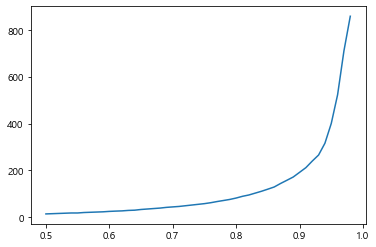

In [119]:
p = np.arange(0.5, 0.99, 0.01)
plt.plot(p, goods.구매수.quantile(p))
plt.show()

인기 상품 기준 = 백분위 0.9 이상

In [120]:
g = goods.loc[goods['구매수'] >= goods['구매수'].quantile(0.9)].reset_index()
g['인기제품여부'] = 1

In [121]:
t=tr[['cust_id','goods_id']]
t=t.merge(g,on='goods_id',how='left').fillna(0)
t.head()

,cust_id,goods_id,구매수,인기제품여부
0,0,127105,2231.0,1.0
1,0,342220,904.0,1.0
2,0,127105,2231.0,1.0
3,0,342205,748.0,1.0
4,0,342220,904.0,1.0


In [122]:
t = t.groupby('cust_id')['인기제품여부'].agg([('인기제품구매수', np.sum)]).reset_index()
t.head()

,cust_id,인기제품구매수
0,0,59.0
1,1,1.0
2,2,0.0
3,3,33.0
4,4,1.0


In [123]:
f = tr.groupby('cust_id')['goods_id'].agg([('구매건수', np.size)]).reset_index()
f = pd.merge(t,f,on='cust_id')
f['인기제품구매율'] = f['인기제품구매수']/f['구매건수']
f = f[['cust_id','인기제품구매율']]
f.head()

,cust_id,인기제품구매율
0,0,0.797297
1,1,0.333333
2,2,0.000000
3,3,0.750000
4,4,0.333333


In [124]:
features = features.merge(f,on='cust_id', how='left'); features.head()

,cust_id,총구매액,구매건수,평균구매액,최대구매액,구매상품종류1,구매상품종류2,구매상품종류3,내점일수,구매주기,...,주로먼저사는품목,특이구매상품(2),WS구입건수,월별구매건수편차,휴면일수,취미용품 구매비율,방문매점 수,아동용품 구매건수,가장 많이 환불된 상품,인기제품구매율
0,0,68282840,74,922741,11264000,35,28,17,19,17,...,기타,"[디자이너, 골프]",0,4.280446,7,0.056338,2,0.0,디자이너,0.797297
1,1,2136000,3,712000,2136000,2,2,2,2,1,...,스포츠,"[트래디셔널, 스포츠]",0,6.144365,67,0.500000,1,0.0,스포츠,0.333333
2,2,3197000,4,799250,1639000,1,2,2,2,1,...,기타,"[남성 캐주얼, 없음]",0,6.144365,355,0.000000,1,0.0,NaN,0.000000
3,3,16077620,44,365400,4935000,24,20,13,18,16,...,수산품,"[침구/수예, 구두]",0,3.657564,17,0.000000,1,2.0,NaN,0.750000
4,4,29050000,3,9683333,24000000,2,3,3,2,85,...,기타,"[보석, 화장품]",0,0.707107,47,0.000000,1,0.0,NaN,0.333333


**[파생변수 74]** 의류소비 - 16

Pink Tax  
같은 제품이나 서비스의 가격이 남성용보다 여성용이 비싼 현상. 의류, 미용 도구, 헤어 스타일링 서비스에서 두드러진다는 의견이 많다. NYC 조사 뉴욕시의 조사에 따르면 기능과 품질이 비슷하지만 여성용 제품은 남성용 제품보다 평균 7% 가량이 더 비싸다고 한다.  
  
가설: 여성의 의류 제품이 남성보다 비쌀 것이다. + 여성의 의류 소비는 남성보다 많을것이다.

In [125]:
#남녀를 구별하기 위한 피쳐 이므로  ['남성정장' , '남성 캐주얼'] 제외, 나머지 의류는 남녀 모두 입을 수 있을거라 가정
cl = ['시티웨어', '디자이너' , '셔츠' , '란제리/내의' , '섬유잡화' ,
      '캐주얼' , '교복' ,'기타의류', '멀티(아울렛)']

In [126]:
t = tr.groupby('cust_id')['amount'].agg([('총구매액',np.sum)])
f = tr.query("gds_grp_mclas_nm == @cl").groupby('cust_id')['amount'].agg([('의류구매비용', np.sum)]).reset_index()
f = pd.merge(t,f, on = 'cust_id', how = 'left').fillna(0)
f

,cust_id,총구매액,의류구매비용
0,0,68282840,26836200.0
1,1,2136000,0.0
2,2,3197000,0.0
3,3,16077620,1609600.0
4,4,29050000,0.0
...,...,...,...
5977,5977,82581500,24950000.0
5978,5978,480000,480000.0
5979,5979,260003790,33210000.0
5980,5980,88991520,0.0


In [127]:
f = f[['cust_id','의류구매비용']]
features = features.merge(f,on='cust_id', how='left'); features.head()

,cust_id,총구매액,구매건수,평균구매액,최대구매액,구매상품종류1,구매상품종류2,구매상품종류3,내점일수,구매주기,...,특이구매상품(2),WS구입건수,월별구매건수편차,휴면일수,취미용품 구매비율,방문매점 수,아동용품 구매건수,가장 많이 환불된 상품,인기제품구매율,의류구매비용
0,0,68282840,74,922741,11264000,35,28,17,19,17,...,"[디자이너, 골프]",0,4.280446,7,0.056338,2,0.0,디자이너,0.797297,26836200.0
1,1,2136000,3,712000,2136000,2,2,2,2,1,...,"[트래디셔널, 스포츠]",0,6.144365,67,0.500000,1,0.0,스포츠,0.333333,0.0
2,2,3197000,4,799250,1639000,1,2,2,2,1,...,"[남성 캐주얼, 없음]",0,6.144365,355,0.000000,1,0.0,NaN,0.000000,0.0
3,3,16077620,44,365400,4935000,24,20,13,18,16,...,"[침구/수예, 구두]",0,3.657564,17,0.000000,1,2.0,NaN,0.750000,1609600.0
4,4,29050000,3,9683333,24000000,2,3,3,2,85,...,"[보석, 화장품]",0,0.707107,47,0.000000,1,0.0,NaN,0.333333,0.0


**[파생변수 75]** 명절(설날,추석) 식료품 구매액 - 16

가설: 설날 및 추석 연휴기간에는 전체적인 식료품의 수요가 늘 것이고 여성의 소비가 많을 것이다.

In [128]:
# 공휴일 패키지 (https://pypi.org/project/pytimekr/)
!pip install pytimekr
from pytimekr import pytimekr
display(pytimekr.lunar_newyear(2007),# 설날
        pytimekr.chuseok(2007))      # 추석

datetime.date(2007, 2, 18)

datetime.date(2007, 9, 25)

In [129]:
###  데이터가 2007년 한 해동안의 데이터 이기때문에 리스트로 대체
# 명절 당일 5일전부터 연휴기간까지
kr_holidays = ['2007-02-13 00:00:00', '2007-02-14 00:00:00', '2007-02-15 00:00:00', '2007-02-16 00:00:00', '2007-02-17 00:00:00', 
               '2007-02-18 00:00:00', '2007-02-19 00:00:00',
               '2007-09-20 00:00:00', '2007-09-21 00:00:00', '2007-09-22 00:00:00', '2007-09-23 00:00:00', '2007-09-24 00:00:00', 
               '2007-09-25 00:00:00', '2007-09-26 00:00:00']

In [130]:
tr.tran_date = tr.tran_date.astype('datetime64')
tr.query("tran_date == @kr_holidays")

,cust_id,tran_date,store_nm,goods_id,gds_grp_nm,gds_grp_mclas_nm,amount,month,season,weekday,holiday,date,season_sale,amount_quarter,man_goods,woman_goods,차원축소,gdsP/N,Mon
81,3,2007-02-13,광주점,35145,회,수산품,24000,2,fall,Tuesday,0,2007-02-13,그 외,amount_2,0,0,식품,0,2
118,3,2007-09-24,광주점,47118,멸치류,수산품,87560,9,fall,Monday,1,2007-09-24,가을 시즌 마감,amount_2,0,0,식품,0,9
119,3,2007-09-24,광주점,64157,떡,가공식품,20000,9,fall,Monday,1,2007-09-24,가을 시즌 마감,amount_2,0,0,식품,0,9
120,3,2007-09-24,광주점,47118,상품군미지정,기타,3980,9,fall,Monday,1,2007-09-24,가을 시즌 마감,amount_1,0,0,기타,0,9
157,7,2007-02-13,본 점,73151,상품군미지정,기타,207000,2,fall,Tuesday,0,2007-02-13,그 외,amount_3,0,0,기타,0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
163504,5979,2007-09-23,본 점,162213,일반핸드백,피혁잡화,616000,9,fall,Sunday,1,2007-09-23,가을 시즌 마감,amount_3,0,1,잡화,0,9
163505,5979,2007-09-23,본 점,50109,일반가공식품,가공식품,1057500,9,fall,Sunday,1,2007-09-23,가을 시즌 마감,amount_4,0,0,식품,0,9
163506,5979,2007-09-23,본 점,50109,상품군미지정,기타,42300,9,fall,Sunday,1,2007-09-23,가을 시즌 마감,amount_2,0,0,기타,0,9
163507,5979,2007-09-23,본 점,996101,상품군미지정,기타,1250,9,fall,Sunday,1,2007-09-23,가을 시즌 마감,amount_1,0,0,기타,0,9


In [131]:
holi_nm=['건강식품', '육류', '수산품', '축산가공', '젓갈/반찬', '가공식품', '농산물', '주류']

In [132]:
f = tr.query("tran_date == @kr_holidays").query("gds_grp_mclas_nm == @holi_nm").groupby('cust_id')['amount'].agg([
    ('명절식품비용', np.sum)]).reset_index()

t = tr.groupby('cust_id')['amount'].agg([('총구매액',np.sum)])
f = pd.merge(t,f,on = 'cust_id', how ='left').fillna(0)
f

,cust_id,총구매액,명절식품비용
0,0,68282840,0.0
1,1,2136000,0.0
2,2,3197000,0.0
3,3,16077620,131560.0
4,4,29050000,0.0
...,...,...,...
5977,5977,82581500,0.0
5978,5978,480000,0.0
5979,5979,260003790,1057500.0
5980,5980,88991520,0.0


In [133]:
f = f[['cust_id','명절식품비용']]
features = features.merge(f,on='cust_id', how='left'); features.head()

,cust_id,총구매액,구매건수,평균구매액,최대구매액,구매상품종류1,구매상품종류2,구매상품종류3,내점일수,구매주기,...,WS구입건수,월별구매건수편차,휴면일수,취미용품 구매비율,방문매점 수,아동용품 구매건수,가장 많이 환불된 상품,인기제품구매율,의류구매비용,명절식품비용
0,0,68282840,74,922741,11264000,35,28,17,19,17,...,0,4.280446,7,0.056338,2,0.0,디자이너,0.797297,26836200.0,0.0
1,1,2136000,3,712000,2136000,2,2,2,2,1,...,0,6.144365,67,0.500000,1,0.0,스포츠,0.333333,0.0,0.0
2,2,3197000,4,799250,1639000,1,2,2,2,1,...,0,6.144365,355,0.000000,1,0.0,NaN,0.000000,0.0,0.0
3,3,16077620,44,365400,4935000,24,20,13,18,16,...,0,3.657564,17,0.000000,1,2.0,NaN,0.750000,1609600.0,131560.0
4,4,29050000,3,9683333,24000000,2,3,3,2,85,...,0,0.707107,47,0.000000,1,0.0,NaN,0.333333,0.0,0.0


**[파생변수 76]** 행사상품구매수 - 06

In [134]:
f = tr[tr.gds_grp_mclas_nm.str.contains('행사') | tr.gds_grp_nm.str.contains('행사')]
f = f.groupby('cust_id')['amount'].agg([
    ('행사상품구매수','count')
])
features = features.merge(f, on = 'cust_id', how = 'left'); features.head()

,cust_id,총구매액,구매건수,평균구매액,최대구매액,구매상품종류1,구매상품종류2,구매상품종류3,내점일수,구매주기,...,월별구매건수편차,휴면일수,취미용품 구매비율,방문매점 수,아동용품 구매건수,가장 많이 환불된 상품,인기제품구매율,의류구매비용,명절식품비용,행사상품구매수
0,0,68282840,74,922741,11264000,35,28,17,19,17,...,4.280446,7,0.056338,2,0.0,디자이너,0.797297,26836200.0,0.0,5.0
1,1,2136000,3,712000,2136000,2,2,2,2,1,...,6.144365,67,0.500000,1,0.0,스포츠,0.333333,0.0,0.0,NaN
2,2,3197000,4,799250,1639000,1,2,2,2,1,...,6.144365,355,0.000000,1,0.0,NaN,0.000000,0.0,0.0,NaN
3,3,16077620,44,365400,4935000,24,20,13,18,16,...,3.657564,17,0.000000,1,2.0,NaN,0.750000,1609600.0,131560.0,NaN
4,4,29050000,3,9683333,24000000,2,3,3,2,85,...,0.707107,47,0.000000,1,0.0,NaN,0.333333,0.0,0.0,NaN


In [135]:
features

,cust_id,총구매액,구매건수,평균구매액,최대구매액,구매상품종류1,구매상품종류2,구매상품종류3,내점일수,구매주기,...,월별구매건수편차,휴면일수,취미용품 구매비율,방문매점 수,아동용품 구매건수,가장 많이 환불된 상품,인기제품구매율,의류구매비용,명절식품비용,행사상품구매수
0,0,68282840,74,922741,11264000,35,28,17,19,17,...,4.280446,7,0.056338,2,0.0,디자이너,0.797297,26836200.0,0.0,5.0
1,1,2136000,3,712000,2136000,2,2,2,2,1,...,6.144365,67,0.500000,1,0.0,스포츠,0.333333,0.0,0.0,NaN
2,2,3197000,4,799250,1639000,1,2,2,2,1,...,6.144365,355,0.000000,1,0.0,NaN,0.000000,0.0,0.0,NaN
3,3,16077620,44,365400,4935000,24,20,13,18,16,...,3.657564,17,0.000000,1,2.0,NaN,0.750000,1609600.0,131560.0,NaN
4,4,29050000,3,9683333,24000000,2,3,3,2,85,...,0.707107,47,0.000000,1,0.0,NaN,0.333333,0.0,0.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5977,5977,82581500,14,5898679,23976000,8,7,7,8,40,...,1.154701,30,0.428571,2,1.0,NaN,0.571429,24950000.0,0.0,NaN
5978,5978,480000,1,480000,480000,1,1,1,1,0,...,6.144365,343,0.000000,1,0.0,NaN,1.000000,480000.0,0.0,NaN
5979,5979,260003790,71,3662025,25750000,38,28,19,19,18,...,5.183891,1,0.028169,1,6.0,NaN,0.211268,33210000.0,1057500.0,NaN
5980,5980,88991520,18,4943973,18120000,9,7,5,5,60,...,1.341641,23,0.000000,1,5.0,NaN,0.777778,0.0,0.0,NaN


<br><font color='green'>
### Feature Correlation

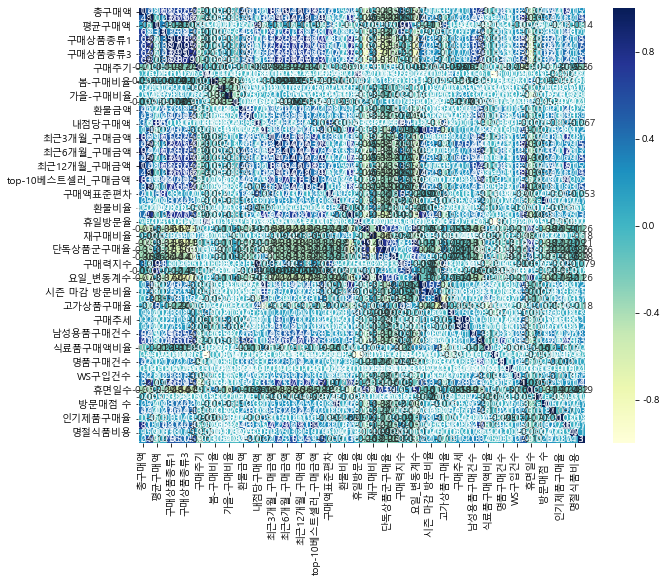

In [136]:
# 상관계수(-1 ~ +1)를 통해 feature 간의 유사성을 파악 
plt.figure(figsize=(10,8))
sns.heatmap(features.iloc[:,1:].corr(), annot=True, cmap="YlGnBu")
plt.show()

import pickle
 #save pickle
with open("features.pickle","wb") as fw:
    pickle.dump(features, fw)

import pickle
 #load pickle
with open("features.pickle","rb") as fr:
    features = pickle.load(fr)

<font color="blue"><p>
## Save Features
- 아래 코드를 수행하면 생성한 모든 파생변수가 학습용과 평가용으로 분리되어 저장된다.

In [137]:
display(features)
features.info()

,cust_id,총구매액,구매건수,평균구매액,최대구매액,구매상품종류1,구매상품종류2,구매상품종류3,내점일수,구매주기,...,월별구매건수편차,휴면일수,취미용품 구매비율,방문매점 수,아동용품 구매건수,가장 많이 환불된 상품,인기제품구매율,의류구매비용,명절식품비용,행사상품구매수
0,0,68282840,74,922741,11264000,35,28,17,19,17,...,4.280446,7,0.056338,2,0.0,디자이너,0.797297,26836200.0,0.0,5.0
1,1,2136000,3,712000,2136000,2,2,2,2,1,...,6.144365,67,0.500000,1,0.0,스포츠,0.333333,0.0,0.0,NaN
2,2,3197000,4,799250,1639000,1,2,2,2,1,...,6.144365,355,0.000000,1,0.0,NaN,0.000000,0.0,0.0,NaN
3,3,16077620,44,365400,4935000,24,20,13,18,16,...,3.657564,17,0.000000,1,2.0,NaN,0.750000,1609600.0,131560.0,NaN
4,4,29050000,3,9683333,24000000,2,3,3,2,85,...,0.707107,47,0.000000,1,0.0,NaN,0.333333,0.0,0.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5977,5977,82581500,14,5898679,23976000,8,7,7,8,40,...,1.154701,30,0.428571,2,1.0,NaN,0.571429,24950000.0,0.0,NaN
5978,5978,480000,1,480000,480000,1,1,1,1,0,...,6.144365,343,0.000000,1,0.0,NaN,1.000000,480000.0,0.0,NaN
5979,5979,260003790,71,3662025,25750000,38,28,19,19,18,...,5.183891,1,0.028169,1,6.0,NaN,0.211268,33210000.0,1057500.0,NaN
5980,5980,88991520,18,4943973,18120000,9,7,5,5,60,...,1.341641,23,0.000000,1,5.0,NaN,0.777778,0.0,0.0,NaN


<class 'pandas.core.frame.DataFrame'>
Int64Index: 5982 entries, 0 to 5981
Data columns (total 77 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   cust_id           5982 non-null   int64         
 1   총구매액              5982 non-null   int64         
 2   구매건수              5982 non-null   int64         
 3   평균구매액             5982 non-null   int64         
 4   최대구매액             5982 non-null   int64         
 5   구매상품종류1           5982 non-null   int64         
 6   구매상품종류2           5982 non-null   int64         
 7   구매상품종류3           5982 non-null   int64         
 8   내점일수              5982 non-null   int64         
 9   구매주기              5982 non-null   int64         
 10  주말방문비율            5982 non-null   float64       
 11  봄-구매비율            5982 non-null   float64       
 12  여름-구매비율           5982 non-null   float64       
 13  가을-구매비율           5982 non-null   float64       
 14  겨울-구매비율           5982 n

In [138]:
X_train = pd.DataFrame({'cust_id': np.sort(train['cust_id'].unique())}).merge(features)
X_train.to_csv('X_train.csv', index=False, encoding='cp949')

X_test = pd.DataFrame({'cust_id': np.sort(test['cust_id'].unique())}).merge(features)
X_test.to_csv('X_test.csv', index=False, encoding='cp949')

## <font color="#CC3D3D"><p>
# End